In [18]:
# import  header
import random
random.seed(1) 
import numpy as np
np.random.seed(1)

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Times New Roman']  
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import re

import plotly.graph_objects as go

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.feature_selection import RFECV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge,Lasso,ElasticNet,SGDRegressor,LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from base_function.base import *

path = %pwd

def mean_relative_error(y_true, y_pred):
    import numpy as np
    relative_error = np.average(np.abs(y_true - y_pred) / y_true, axis=0)
    return relative_error

def Linear_SVR(C=1.0,gamma=0.1,epsilon=1):
    return Pipeline([
        ("std_scaler",StandardScaler()),
        ("model",SVR(kernel="linear",C=C,gamma=gamma,epsilon=epsilon))
    ])
def RBF_SVR(C=1.0,gamma=1,epsilon=1):
    return Pipeline([
        ("std_scaler",StandardScaler()),
        ("model",SVR(kernel="rbf",C=C,gamma=gamma,epsilon=epsilon))
    ])
def Poly_LinearRegression(degree=2):
    return Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression())])
def draw_feature_importance(features,feature_importance):
    """ 
    features: name
    feature_importance:
    """
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(dpi=400)
    plt.barh(pos, list(feature_importance[sorted_idx]), align='center')
    plt.yticks(pos, list(features[sorted_idx]))
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.show()
def model_fit_evaluation(model, x_train, y_train, x_test, y_test, n_fold=5):
    """clf: 
    x_train：训练集+验证集 用于计算交叉验证误差  np.array
    y_train： np.array
    x_test：计算测试误差
    n_fold：交叉验证折数 default = 5 
    """
    kf = KFold(n_splits=n_fold,shuffle=True,random_state=0)
    print(model)
    result = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(kf.split(range(len(x_train)))):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_validation = x_train[test_index]  # get validation set
        y_validation = y_train[test_index]  
        model.fit(x_tr, y_tr)
        
        result_subset = pd.DataFrame()  # save the prediction
        result_subset["y_validation"] = y_validation
        result_subset["y_pred"] = model.predict(x_validation)
        result = result.append(result_subset)
    print("cross_validation_error in validation set：")
    c = evaluate_model_plot(result["y_validation"],result["y_pred"],show=False)
    
    print("error in testing set：")
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    error_metric_testing = evaluate_model_plot(y_test,y_test_pred,show=False)
    print("====================================")
    return error_metric_testing
def fatigue_mre_metric(y_true, y_predict):
    """
    calculate the mre of fatigue life
    """
    return mean_relative_error(np.power(10,y_true), np.power(10,y_predict))
# LOGCV for selection features 
def get_score_logcv(X_train,Y_train,groups_array_train,model):
    """
    groups_array_train:groups of S-N curve
    return the MRE of LOGCV
    """
    logo = LeaveOneGroupOut()
    y_predict_list = []
    y_true_list = []
    index_list = []

    x = X_train.values
    y = Y_train.values
    for train_index, test_index in logo.split(x, y, groups_array_train):# LOOGV
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(x_train,y_train)
        y_predict_list.extend(model.predict(x_test))
        y_true_list.extend(y_test)
        index_list.extend(index[test_index])
    
    # calculate metric
    mre = mean_relative_error(np.power(10,y_true_list), np.power(10,y_predict_list))
    return mre

# Fatigue Strength modeling

## data preprocessing

In [4]:
#1 reading data
dataset = pd.read_excel(path+r'/data.xlsx',sheet_name="fatigue_strength")
# extract tempers
condition_list = []
# same alloy with different temps has same name
name_list=[]
for i in dataset["url"]:
    #print(i)
    condition = re.findall("-([OF]|[HT]\d+)-",i)[0]
    condition_list.append(condition)
    name = i.replace(r"https://www.makeitfrom.com/material-properties/","")
    name = name.replace(condition,"")
    name_list.append(name)
dataset["tempers"] = condition_list
dataset = dataset.drop(["url"],axis=1)
dataset = dataset.fillna(0)
dataset.head()

Al     Fe     Si     Zn     Cu      V   Zr   Ag     Mn   Ni  ...  \
0  99.750  0.200  0.120  0.030  0.030  0.030  0.0  0.0  0.030  0.0  ...   
1  99.800  0.175  0.125  0.025  0.025  0.025  0.0  0.0  0.015  0.0  ...   
2  99.650  0.350  0.350  0.025  0.050  0.000  0.0  0.0  0.025  0.0  ...   
3  99.525  0.400  0.075  0.050  0.010  0.000  0.0  0.0  0.025  0.0  ...   
4  99.525  0.400  0.075  0.050  0.010  0.000  0.0  0.0  0.025  0.0  ...   

      Mg    B   Ga   Cr   Pb   Bi   Li   Co  Fatigue Strength  tempers  
0  0.030  0.0  0.0  0.0  0.0  0.0  0.0  0.0                31     H112  
1  0.015  0.0  0.0  0.0  0.0  0.0  0.0  0.0                15     H112  
2  0.025  0.0  0.0  0.0  0.0  0.0  0.0  0.0                47     H112  
3  0.025  0.0  0.0  0.0  0.0  0.0  0.0  0.0                42      H12  
4  0.025  0.0  0.0  0.0  0.0  0.0  0.0  0.0                49      H14  

[5 rows x 23 columns]

In [5]:
#2 data processing
# condition label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset["tempers"]=le.fit_transform(dataset["tempers"])

# save the LabelEncoder
import pickle
with open ("le_tempers.txt", 'wb') as f:
    pickle.dump(le, f)

In [6]:
#3 machine leanrning model
Y_columns = "Fatigue Strength"
X = dataset.drop([Y_columns],axis=1).values
Y = dataset[Y_columns].values
X_columns = dataset.drop([Y_columns],axis=1).columns

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size=0.3,random_state=0)

In [6]:
# hyper-paramerer 
def hyper_param_opt_model(X, y,model,param_grid):
    """
    hyper-paramerer optimize by GridSearch
    """
    gsc = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5, 
        scoring= 'neg_mean_squared_error',
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    return best_params

print('The best parameters: ',hyper_param_opt_model(X_train,Y_train,RandomForestRegressor(random_state=1),param_grid={
            'max_depth': range(11,16),
            'n_estimators': (5,50,100,200,1000)}))


The best parameters:  {'max_depth': 15, 'n_estimators': 1000}


## model evalucation

RandomForestRegressor(max_depth=15, n_estimators=1000, random_state=0)
cross_validation_error in validation set：
样本个数  738
均方根误差RMSE  18.339
均方差MSE  336.335
平均绝对误差MAE  12.573
R2： 0.804
error in testing set：
样本个数  317
均方根误差RMSE  15.775
均方差MSE  248.852
平均绝对误差MAE  10.881
R2： 0.871


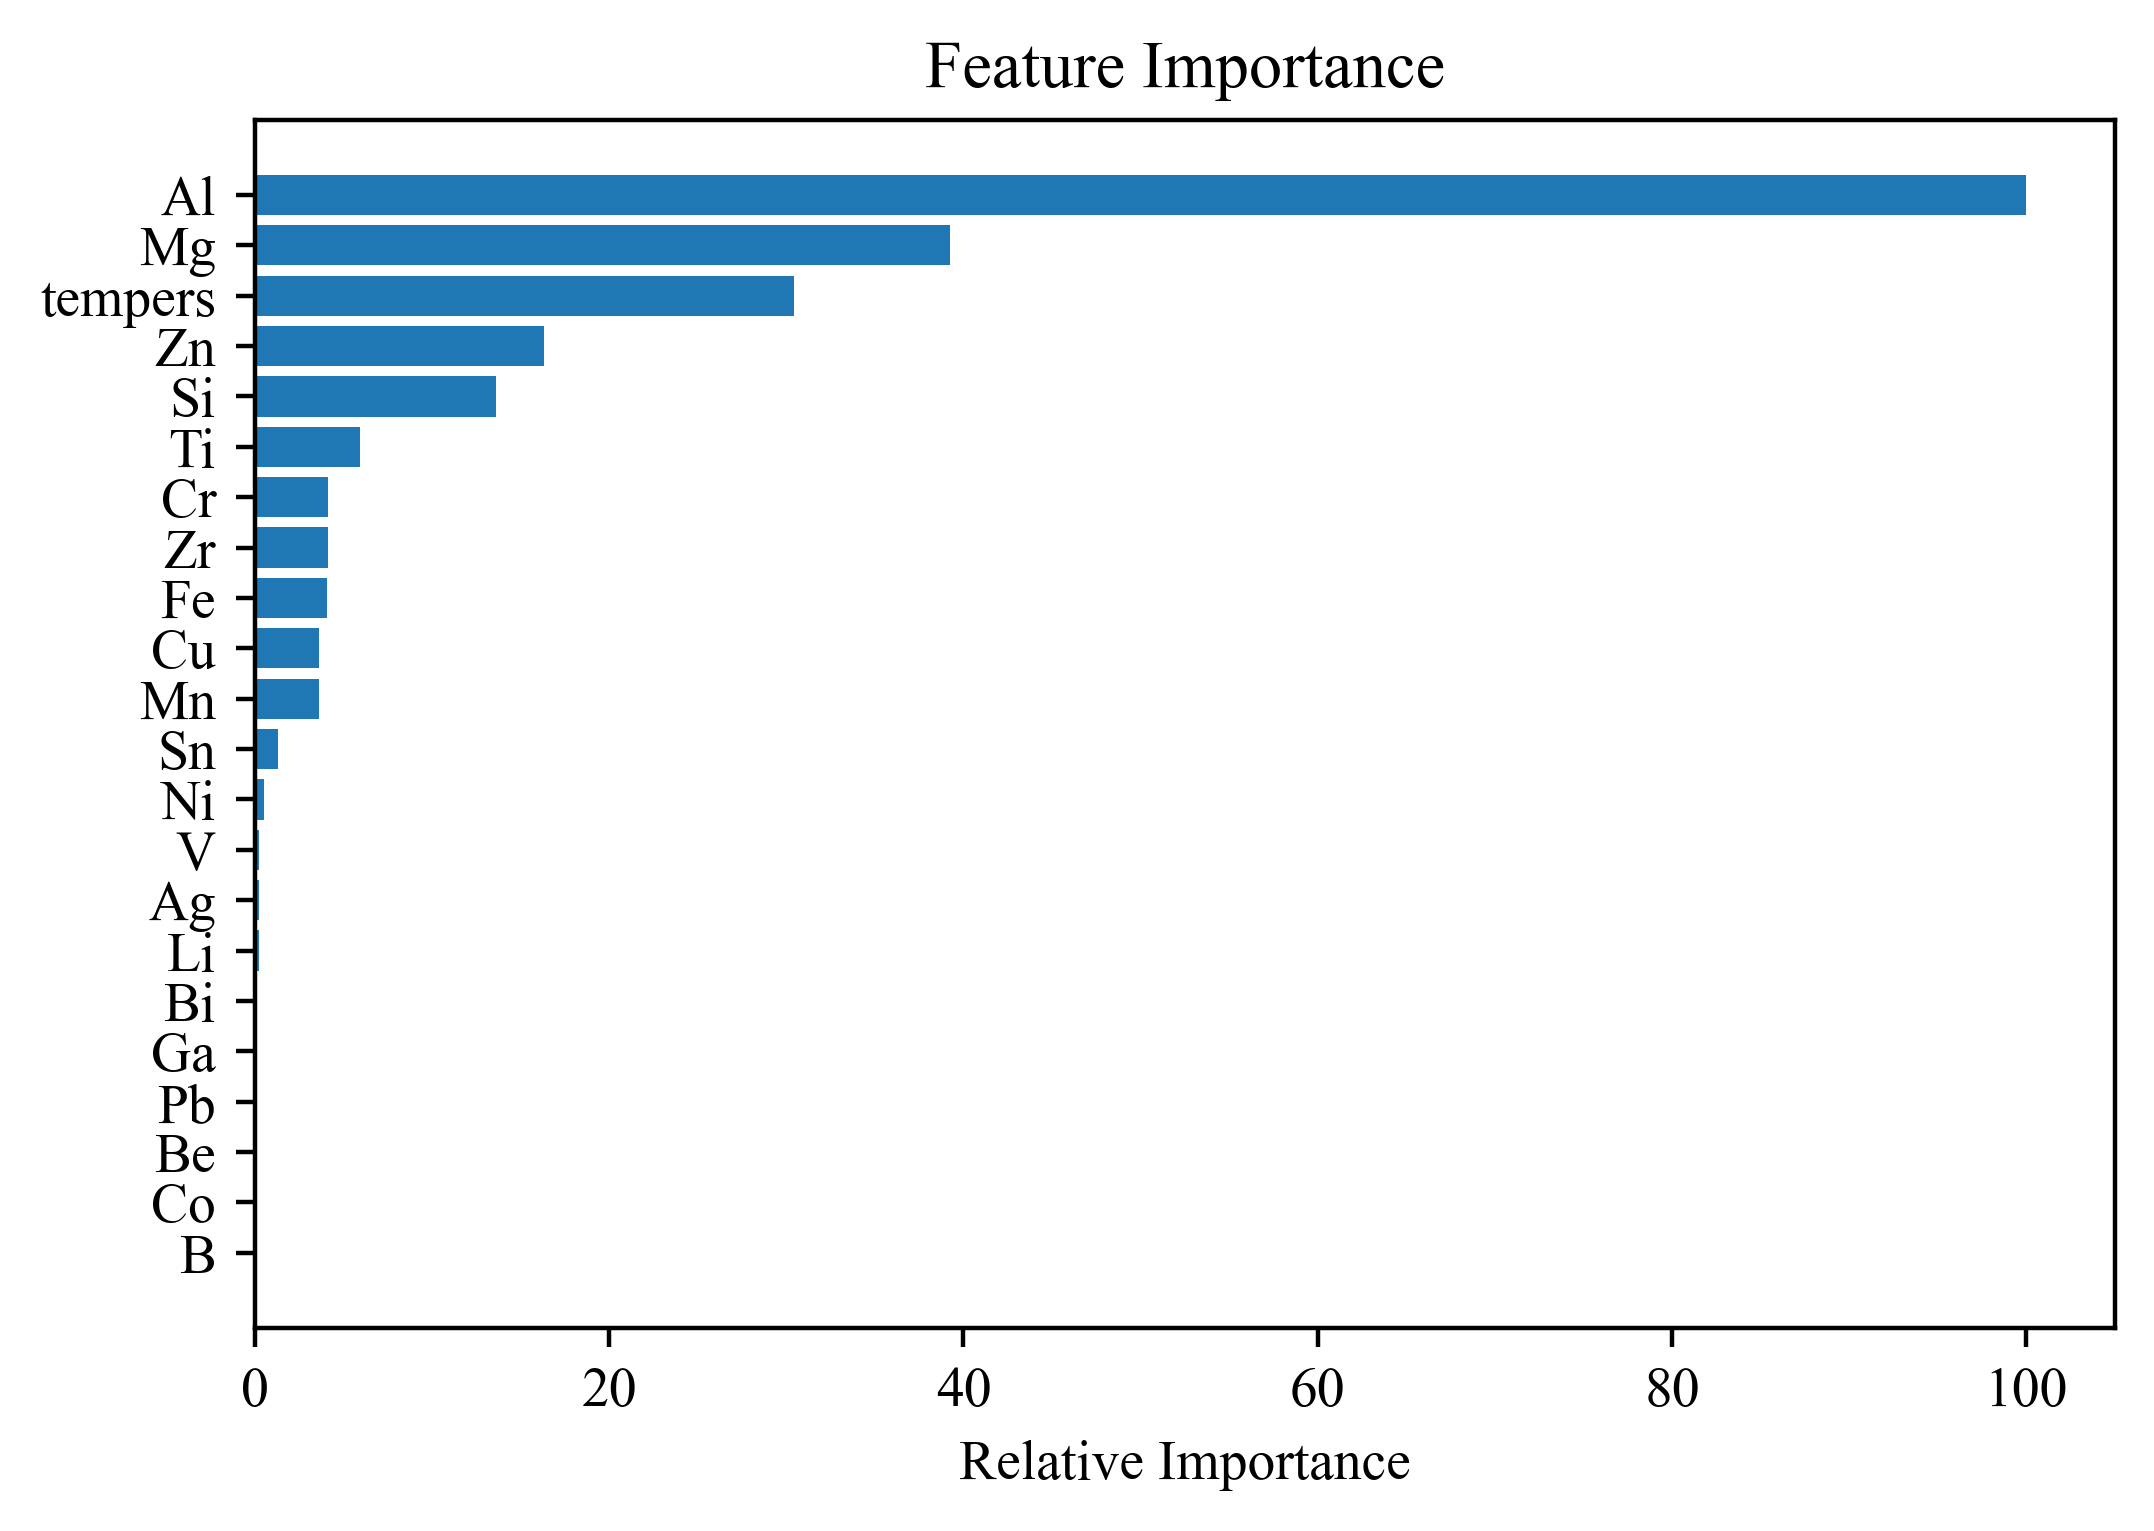

model      RMSE       MAE        R2
0  RandomForest  15.77505  10.88096  0.870807

In [6]:
rfr = RandomForestRegressor(max_depth=15,n_estimators=1000,random_state=0)
model_dict = {"RandomForest":rfr}
# record the error
RMSE_list = []
MAE_list = []
R2_list = []

for model in model_dict.values():
    error_metric_testing = model_fit_evaluation(model, X_train, Y_train, X_test,Y_test, n_fold=5)
    RMSE_list.append(error_metric_testing["RMSE"])
    MAE_list.append(error_metric_testing["MAE"])
    R2_list.append(error_metric_testing["R2"])
result_df = pd.DataFrame({"model":list(model_dict.keys()),"RMSE":RMSE_list,
                          "MAE":MAE_list,"R2":R2_list})
features = dataset.drop([Y_columns],axis=1).columns
feature_importance = rfr.feature_importances_
draw_feature_importance(features,feature_importance)
result_df

In [13]:
rfr.fit(X_train, Y_train)
y_predict = rfr.predict(X_test)

In [14]:
R2 = round(error_metric_testing["R2"],2)
MAE = round(error_metric_testing["MAE"],2)
RMSE = round(error_metric_testing["RMSE"],2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


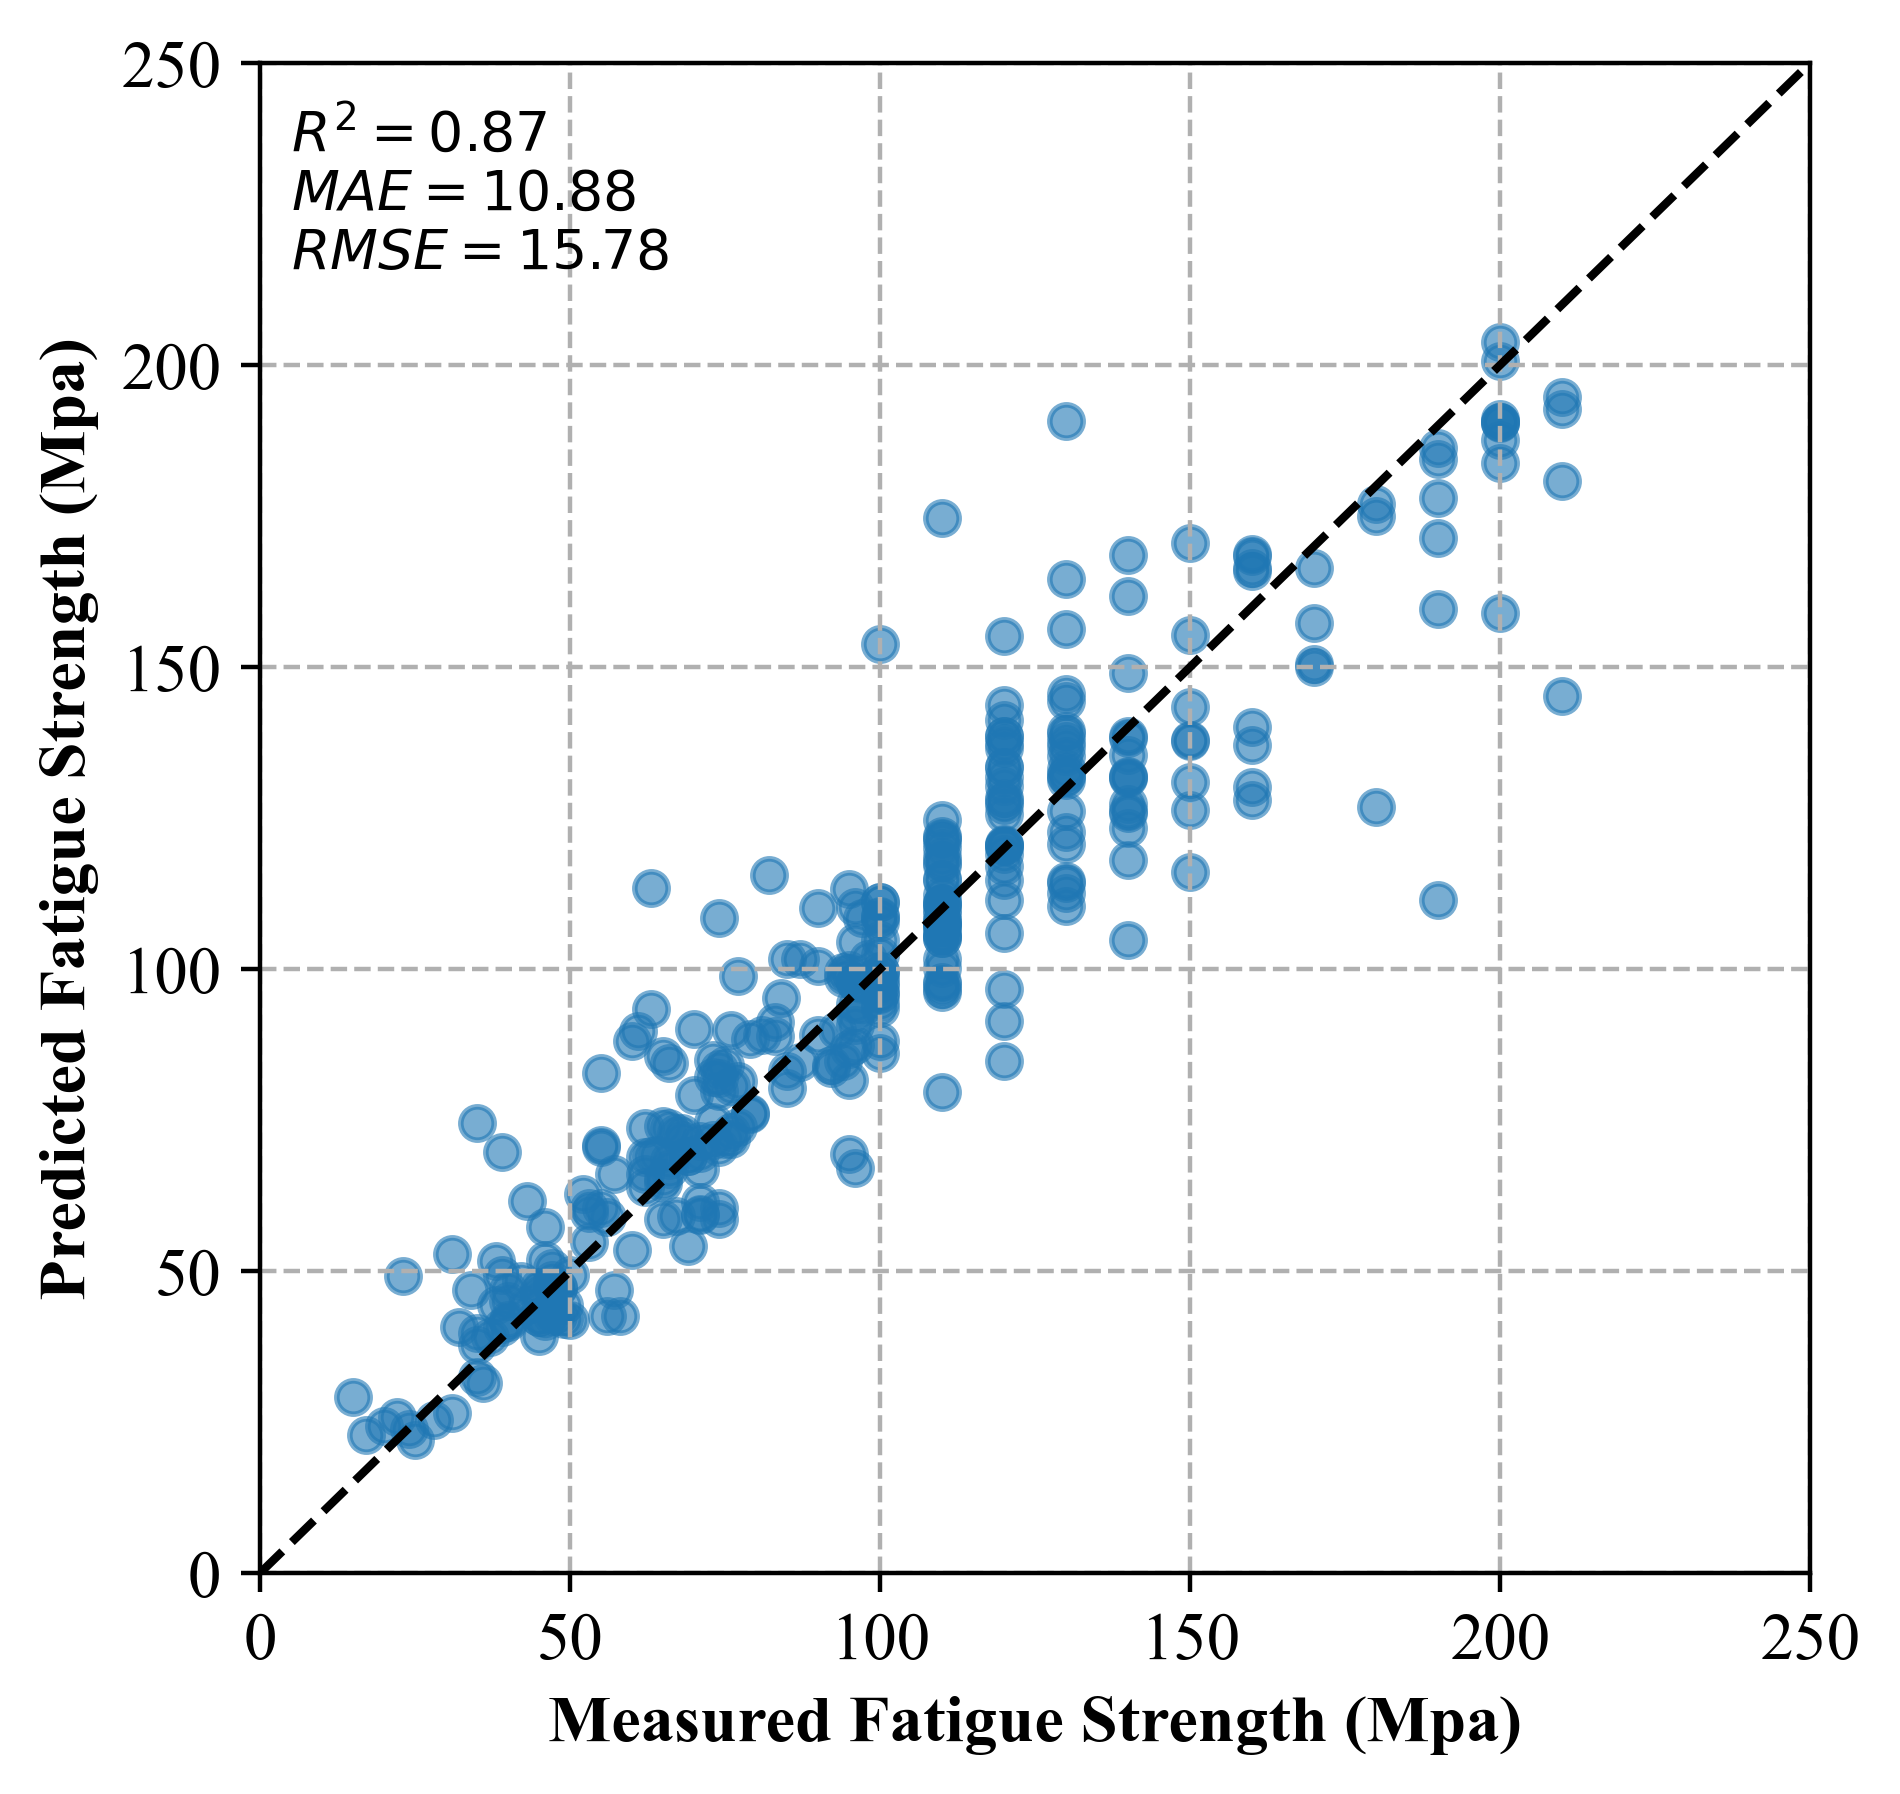

In [15]:
plt.figure(figsize=(5, 5), dpi=400)
plt.grid(linestyle="--")
plt.scatter(list(Y_test),list(y_predict),alpha=0.6)
plt.plot([0, 250], [0, 250],color='black',linestyle="--")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Measured Fatigue Strength (Mpa)", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Fatigue Strength (Mpa)", fontsize=12, fontweight='bold')
# set axis scale
plt.xlim(0, 250)
plt.ylim(0, 250)

plt.text(5,216,f"$R^2={R2}$\n$MAE={MAE}$\n$RMSE={RMSE}$")

plt.savefig('./FS_evaluation.eps', format='eps')
plt.show()

In [8]:
model_final = RandomForestRegressor(max_depth=15,n_estimators=1000,random_state=0)
model_final.fit(X,Y)
with open ("fatigue_strength_model.pickle", 'wb') as f:
    pickle.dump(model_final, f)

## predict fatigue strength

In [8]:
#6 
# calculate fatigue_strength_prediction in S-N curve
with open ("le_tempers.txt", 'rb') as f:
    le = pickle.load(f)
with open ("fatigue_strength_model.pickle", 'rb') as f:
    model_fs = pickle.load(f)
    
dataset_main = pd.read_excel(r'./data.xlsx',sheet_name= "aluminium alloy data")
temps = le.transform(dataset_main["Temper"].values.reshape(-1,1))
dataset_Comp = pd.read_excel(r'./data.xlsx',sheet_name= "Composition")

# 元素weight df
X_column_element = ["Al","Fe","Si","Zn","Cu","V","Zr","Ag","Mn","Ni","Sn","Be","Ti","Mg","B","Ga","Cr","Pb","Bi","Li","Co"]
elements_col = ["Al","Si","Ti","Mn","Fe","Ni","Cu","Zn","Mg","Cr","Sn","Pb","Zr"]
df_element = pd.DataFrame(columns=X_column_element)
df_element = df_element.append(dataset_Comp[elements_col]).fillna(0)
df_element["Composition"] = dataset_Comp["Composition"]


# get temps
df_temper = pd.DataFrame(temps,columns=["temps"])
df_temper["Composition"]= dataset_main["Composition"]
df_predict = pd.merge(df_element,df_temper, how='inner')
df_predict = df_predict.drop(["Composition"],axis=1)
df_predict.head(10)
# predict for 54  S-N curves
fs_predict = model_fs.predict(df_predict)
fs_predict

array([101.92400443, 101.92400443, 101.92400443, 101.92400443,
       101.92400443,  87.36633625,  88.40874892,  90.89462771,
        77.65921468,  90.93085735,  83.02503968,  91.01868501,
        89.61402632,  90.81344399,  90.7305    ,  91.325     ,
        91.325     , 117.99892063, 117.99892063, 117.99892063,
       194.80550315, 194.80550315, 194.80550315, 194.80550315,
       194.80550315, 194.80550315, 194.80550315, 194.80550315,
       194.80550315, 194.80550315, 192.54007656, 192.54007656,
       192.54007656, 192.54007656, 192.54007656, 189.74495752,
       189.74495752, 189.74495752, 189.74495752, 189.74495752,
       138.09655556, 138.09655556, 138.09655556, 138.09655556,
       138.09655556, 138.09655556, 138.09655556, 131.67233333,
       131.67233333, 131.67233333, 131.67233333, 131.67233333,
       131.67233333, 131.67233333])

In [10]:
# save the prediction
np.savetxt("fs_predict.txt",fs_predict)

## shap

In [9]:
import shap
X = dataset.drop([Y_columns],axis=1)
explainer = shap.TreeExplainer(model_fs,feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X)

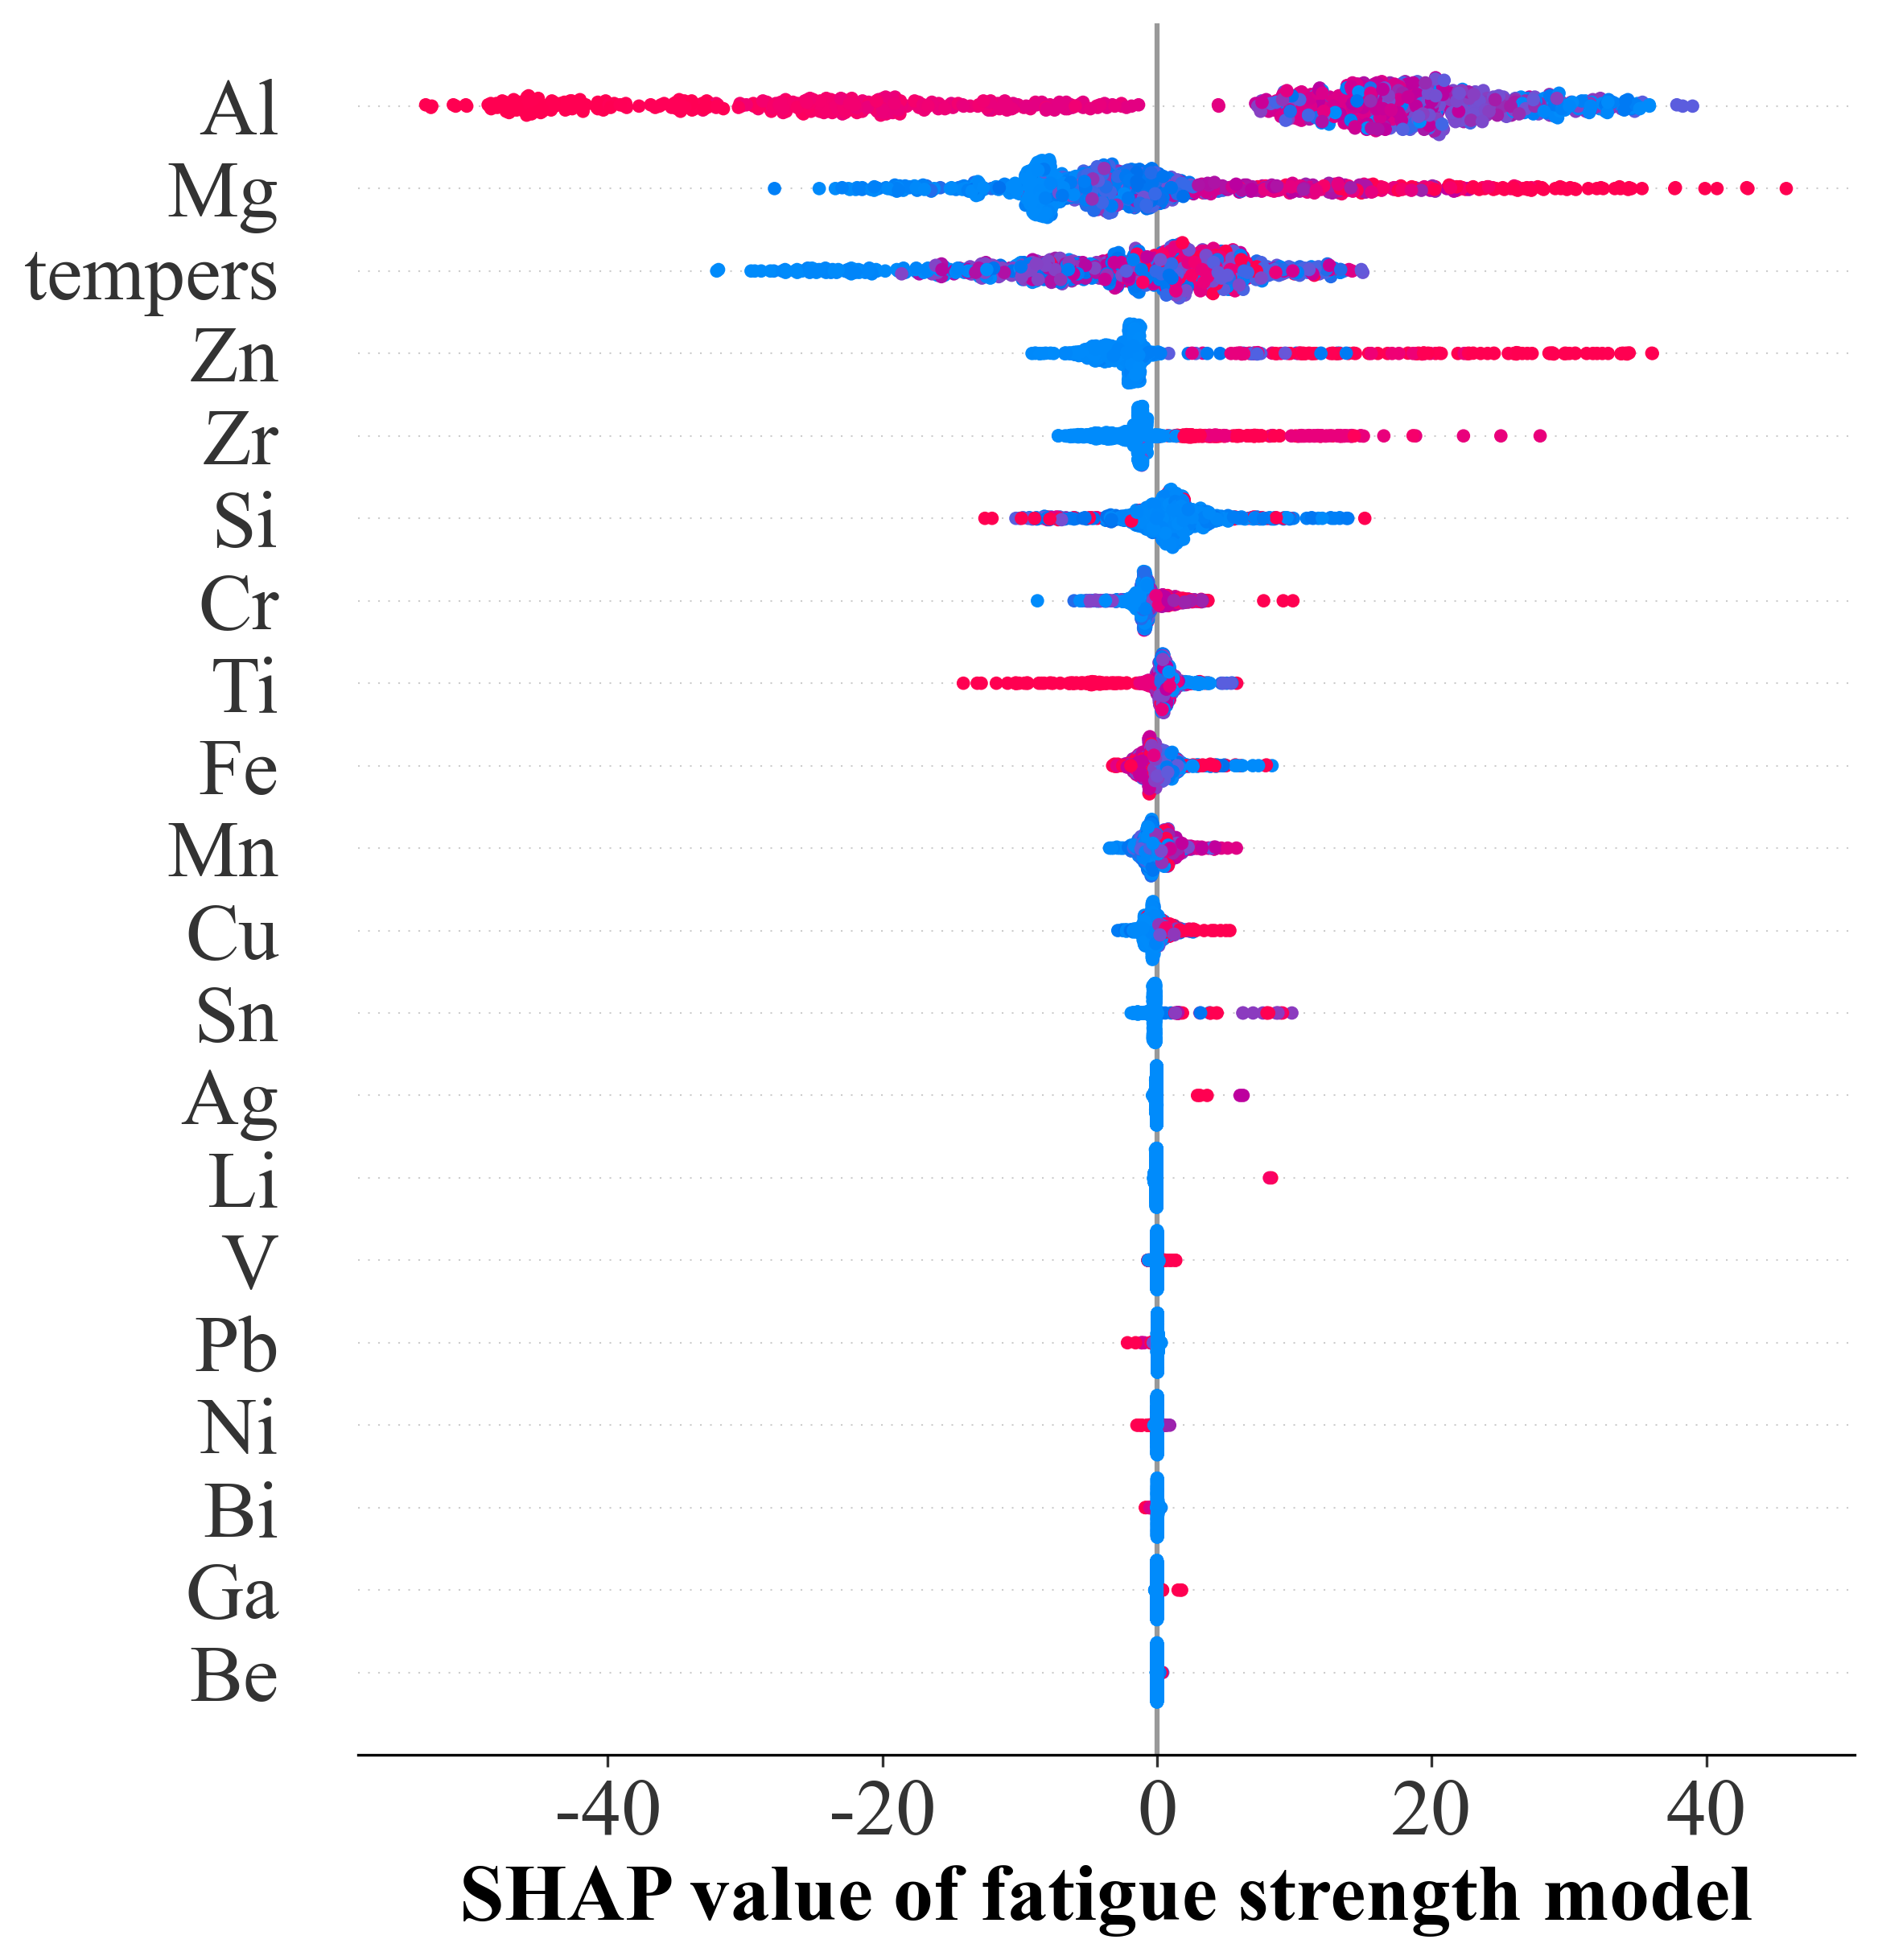

In [10]:
plt.figure(dpi=300)
shap.summary_plot(shap_values, X,show=False,color_bar=False)
plt.xlabel("SHAP value of fatigue strength model" ,fontweight='bold',fontsize=24)
plt.tick_params(labelsize=24,)
plt.show()

# S-N curve modeling

## data preprocessing

In [70]:
fs_predict = np.loadtxt("fs_predict.txt")

There are 54 S-N curves with 609 experiment points
There are runout 127 experiment points
one of the S-N curve


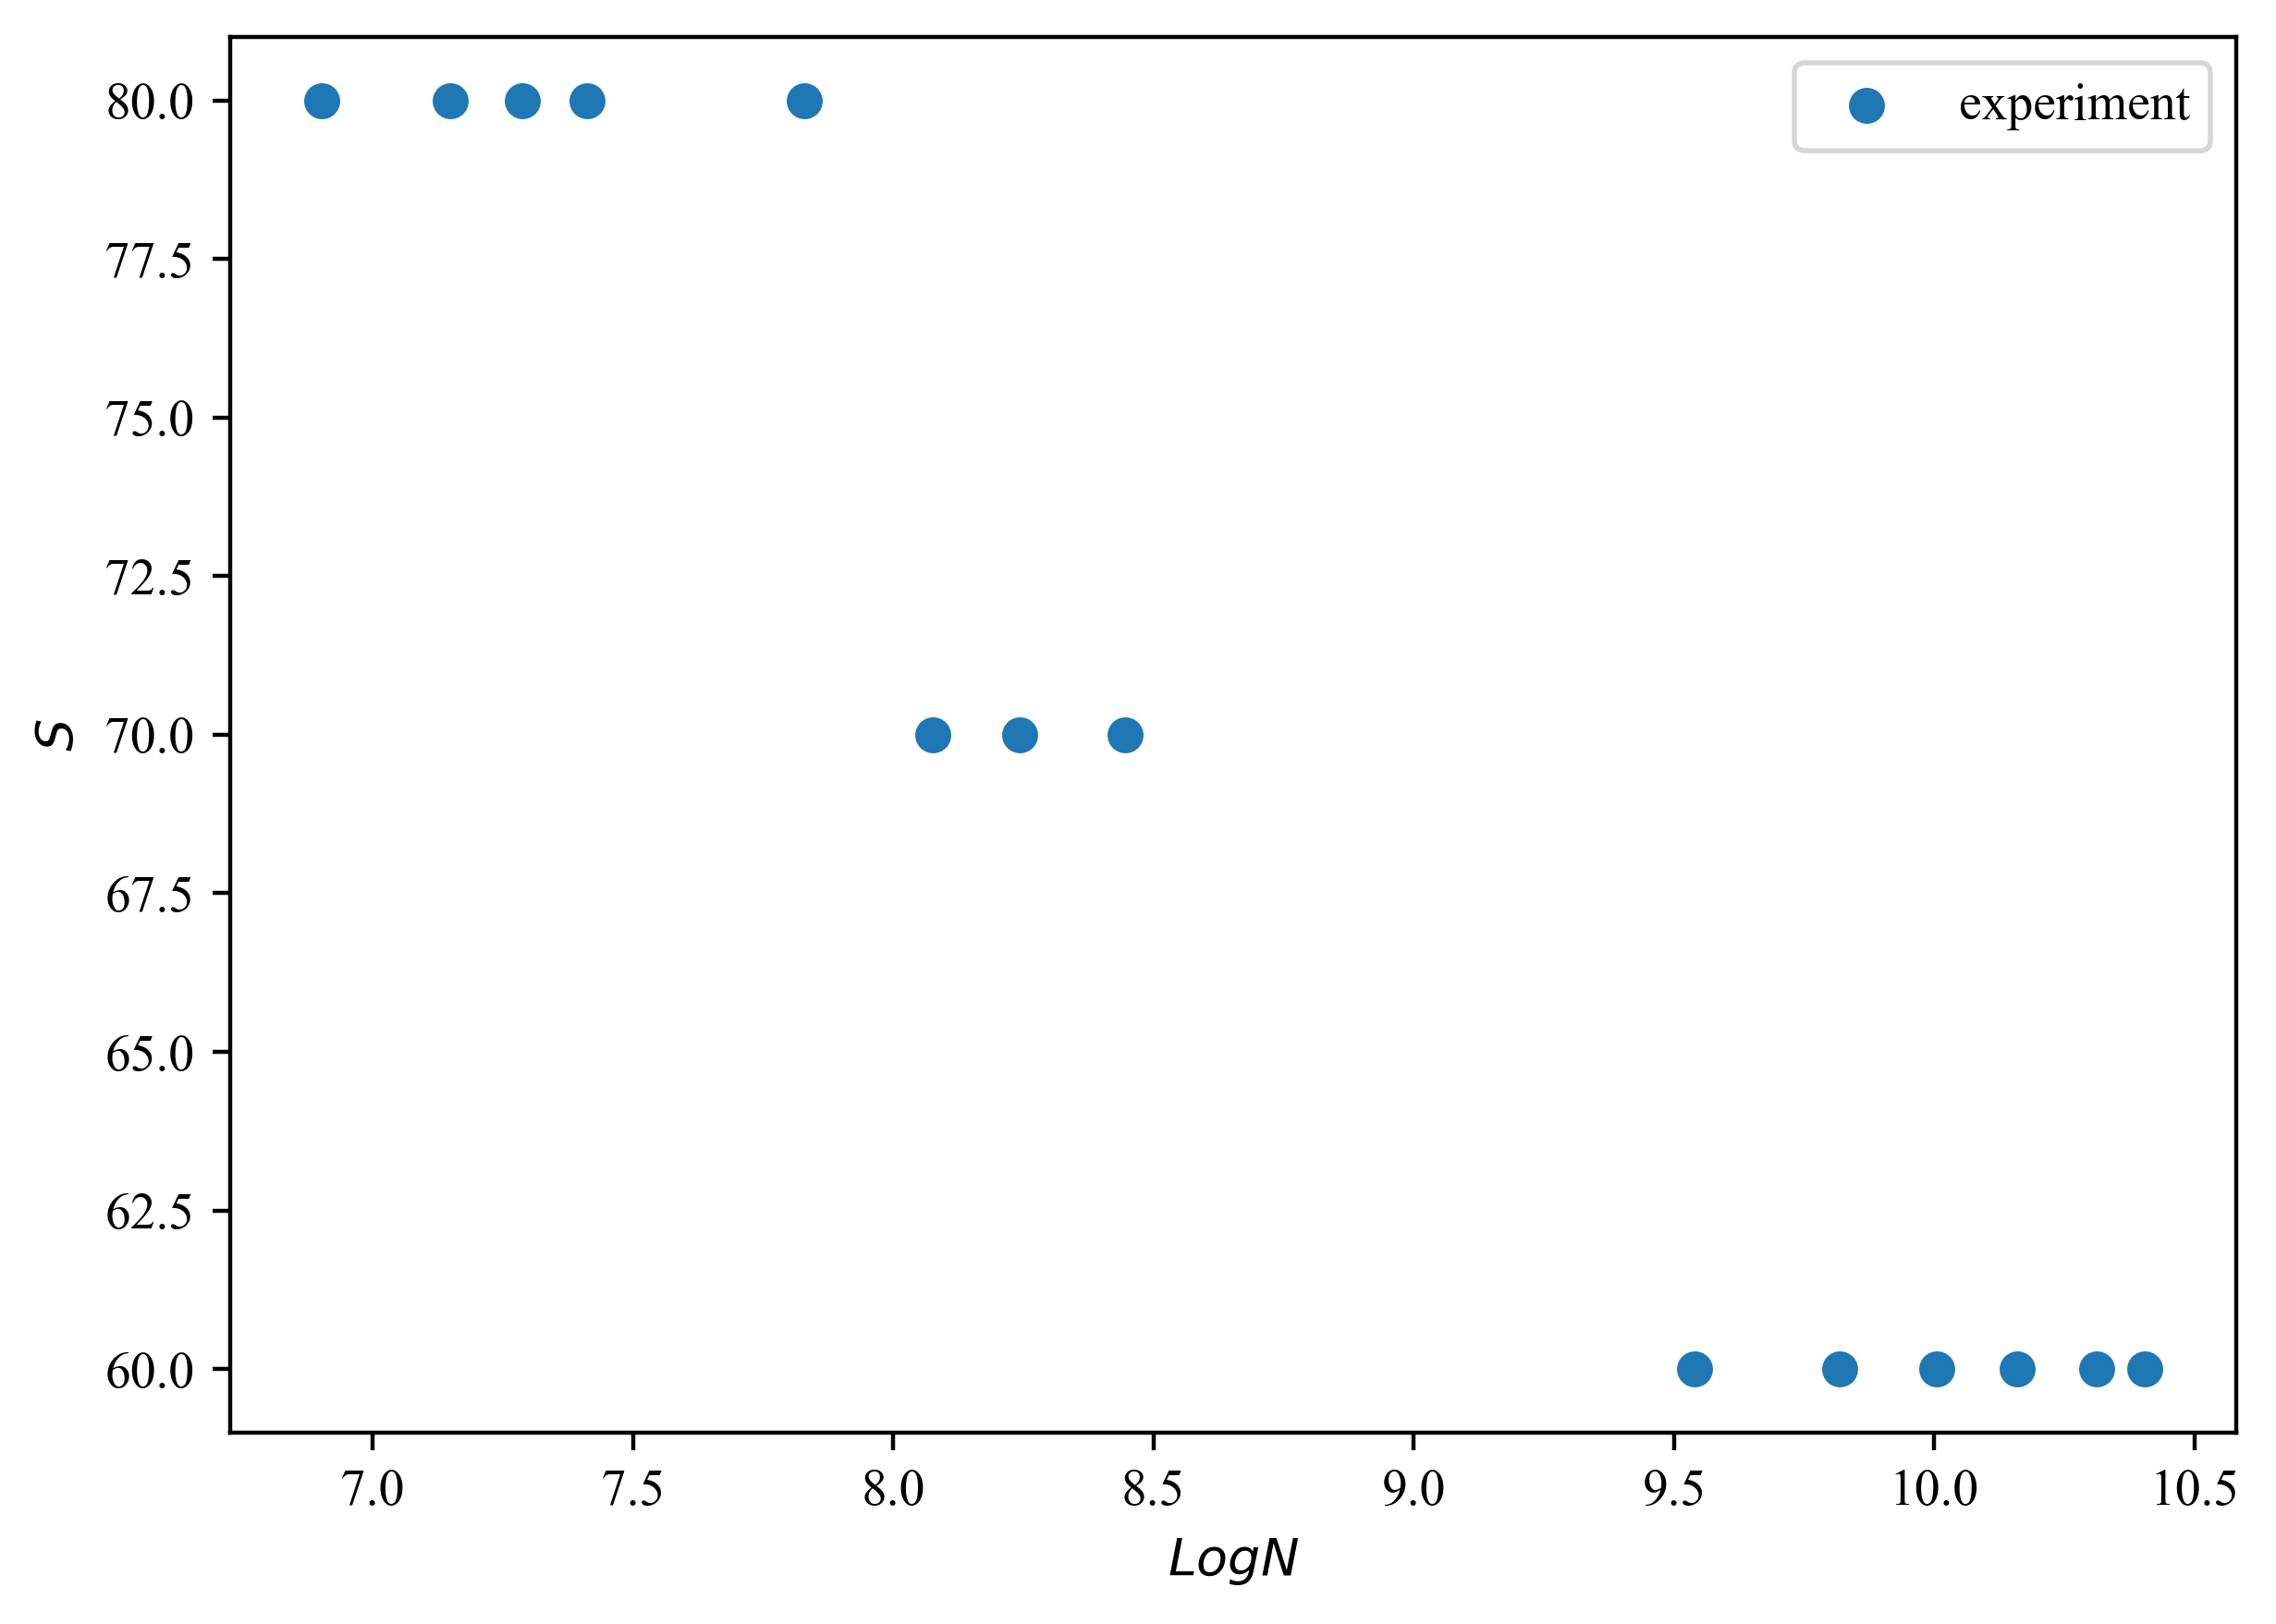

257


In [11]:
dataset_main = pd.read_excel(r'./data.xlsx',sheet_name= "aluminium alloy data")
dataset_SN = pd.read_excel(r'./data.xlsx',sheet_name= "S_N curve")
dataset_Comp = pd.read_excel(r'./data.xlsx',sheet_name= "Composition")
dataset_main["Fatigue Strength"] = fs_predict
data_all = pd.merge(dataset_main, dataset_SN, how='inner')
print("There are {} S-N curves with {} experiment points".
      format(dataset_main.shape[0],dataset_SN.shape[0]))
print("There are runout {} experiment points".
      format(dataset_SN[dataset_SN["runout"]==">"].shape[0]))
print("one of the S-N curve")

# show one S-N
plt.figure(figsize=(7, 5), dpi=400)
df_temp = dataset_SN[dataset_SN["S-N_index"]==19]
plt.scatter(df_temp["LgN"],df_temp["S"],label="experiment")
plt.xlabel("$LogN$")
plt.ylabel("$S$")
plt.legend()
plt.show()

# exclude the runout data
dataset_SN = dataset_SN[dataset_SN["runout"]!=">"]
S_N_index = list(dataset_main["S-N_index"].unique())

# get averaged S-N curve
df_all = pd.merge(dataset_main, dataset_SN, how='inner')
coulumns = ["S-N_index","UTS","TYS","R","S","LgN","Fatigue Strength"]
# all data
df_curve = df_all[coulumns].groupby(["S-N_index","UTS","TYS","R","S","Fatigue Strength"],as_index=False).mean()

print("{}".format(df_curve.shape[0]))

## feature engenering

In [12]:
# used for LOOGV
groups_array = np.array(df_curve["S-N_index"])

# feature engenering
df_curve["$Logσ_{a}$"]=df_curve["S"].apply(np.log10)
df_curve["Stussi"] = (df_curve["UTS"]-df_curve["S"])/(df_curve["S"]-df_curve["Fatigue Strength"]+100)
df_curve["Stussi"] = df_curve["Stussi"].apply(np.log)

df_curve["$σ_{a}^3$"]= df_curve["S"].apply(lambda x: np.power(x,3))
df_curve["$σ_{a}^2$"]= df_curve["S"].apply(lambda x: np.power(x,2))
df_curve["$σ_{a}^{0.5}$"]= df_curve["S"].apply(np.sqrt)
df_curve["$σ_{a}^{0.1}$"]=df_curve["S"].apply(lambda x: np.power(x,0.1))


Smin = "$σ_{min}$"
Smax = "$σ_{max}$"
Savg = "$σ_{m}$"
df_curve[Smax] = 2*df_curve["S"]/(1-df_curve["R"])
df_curve[Smin] = df_curve[Smax]*df_curve["R"]
df_curve[Savg] = (np.abs(df_curve[Smin])+np.abs(df_curve[Smax]))/2

# Smin
df_curve["$σ_{min}^{0.1}$"]=abs(df_curve[Smin]).apply(lambda x: np.power(x,0.1))
df_curve["$σ_{min}^{0.5}$"]=abs(df_curve[Smin]).apply(np.sqrt)
df_curve["$σ_{min}^{1.5}$"]=abs(df_curve[Smin]).apply(lambda x: np.power(x,1.5))
df_curve["$σ_{min}^2$"]=df_curve[Smin].apply(lambda x: np.power(x,2))
df_curve["$σ_{min}^{2.5}$"]=abs(df_curve[Smin]).apply(lambda x: np.power(x,2.5))
df_curve["$σ_{min}^3$"]=df_curve[Smin].apply(lambda x: np.power(x,3))
# Smax                                 
df_curve["$σ_{max}^{0.1}$"]=abs(df_curve[Smax]).apply(lambda x: np.power(x,0.1))                                          
df_curve["$σ_{max}^{0.5}$"]=abs(df_curve[Smax]).apply(np.sqrt)
df_curve["$σ_{max}^{1.5}$"]=abs(df_curve[Smax]).apply(lambda x: np.power(x,1.5))
df_curve["$σ_{max}^2$"]=df_curve[Smax]*df_curve[Smax]
df_curve["$σ_{max}^{2.5}$"]=abs(df_curve[Smax]).apply(lambda x: np.power(x,2.5))
df_curve["$σ_{max}^3$"]=df_curve[Smax]*df_curve[Smax]*df_curve[Smax]
c = list(df_curve.columns)
c[4] = "$σ_{a}$"
df_curve.columns = c

X = df_curve.drop(["S-N_index","LgN"],axis=1).values
X_columns = df_curve.drop(["S-N_index","LgN"],axis=1).columns
Y = df_curve["LgN"]
index = df_curve["S-N_index"]
features = df_curve.drop(["S-N_index","LgN"],axis=1).columns
Y_column = "LgN"
df_curve.head(10)

S-N_index  UTS  TYS    R  $σ_{a}$  Fatigue Strength       LgN  $Logσ_{a}$  \
0          1  464  438  0.1     80.0        101.924004  7.496930    1.903090   
1          1  464  438  0.1    100.0        101.924004  5.773786    2.000000   
2          1  464  438  0.1    130.0        101.924004  5.033424    2.113943   
3          1  464  438  0.1    150.0        101.924004  4.673942    2.176091   
4          1  464  438  0.1    170.0        101.924004  4.416641    2.230449   
5          1  464  438  0.1    200.0        101.924004  3.831230    2.301030   
6          2  464  438  0.1     80.0        101.924004  6.610660    1.903090   
7          2  464  438  0.1     90.0        101.924004  6.167317    1.954243   
8          2  464  438  0.1    100.0        101.924004  5.413300    2.000000   
9          2  464  438  0.1    110.0        101.924004  5.176091    2.041393   

     Stussi  $σ_{a}^3$  ...  $σ_{min}^{1.5}$  $σ_{min}^2$  $σ_{min}^{2.5}$  \
0  1.592960   512000.0  ...        74.957693   316.049383      1332.581203   
1  1.311411  1000000.0  ...       104.756560   493.827160      2327.923559   
2  0.958517  2197000.0  ...       155.273112   834.567901      4485.667685   
3  0.751667  3375000.0  ...       192.450090  1111.111111      6415.002991   
4  0.559164  4913000.0  ...       232.195934  1427.160494      8771.846414   
5  0.287298  8000000.0  ...       296.296296  1975.308642     13168.724280   
6  1.592960   512000.0  ...        74.957693   316.049383      1332.581203   
7  1.446056   729000.0  ...        89.442719   400.000000      1788.854382   
8  1.311411  1000000.0  ...       104.756560   493.827160      2327.923559   
9  1.186462  1331000.0  ...       120.856568   597.530864      2954.271661   

    $σ_{min}^3$  $σ_{max}^{0.1}$  $σ_{max}^{0.5}$  $σ_{max}^{1.5}$  \
0   5618.655693         1.678757        13.333333      2370.370370   
1  10973.936900         1.716638        14.907120      3312.693300   
2  24109.739369         1.762273        16.996732      4910.166939   
3  37037.037037         1.787672        18.257419      6085.806195   
4  53914.951989         1.810188        19.436506      7342.680164   
5  87791.495199         1.839847        21.081851      9369.711586   
6   5618.655693         1.678757        13.333333      2370.370370   
7   8000.000000         1.698646        14.142136      2828.427125   
8  10973.936900         1.716638        14.907120      3312.693300   
9  14606.310014         1.733078        15.634719      3821.820249   

     $σ_{max}^2$  $σ_{max}^{2.5}$   $σ_{max}^3$  
0   31604.938272     4.213992e+05  5.618656e+06  
1   49382.716049     7.361541e+05  1.097394e+07  
2   83456.790123     1.418493e+06  2.410974e+07  
3  111111.111111     2.028602e+06  3.703704e+07  
4  142716.049383     2.773901e+06  5.391495e+07  
5  197530.864198     4.164316e+06  8.779150e+07  
6   31604.938272     4.213992e+05  5.618656e+06  
7   40000.000000     5.656854e+05  8.000000e+06  
8   49382.716049     7.361541e+05  1.097394e+07  
9   59753.086420     9.342227e+05  1.460631e+07  

[10 rows x 28 columns]

In [13]:
# independent testing set
test_index = [4,6,9,15,18,21,41]
df_test = pd.DataFrame()
for test_curve in test_index:
    df_test = df_test.append(df_curve[df_curve["S-N_index"]==test_curve])
#df_test["S-N_index"].unique()

### feature selection

In [14]:
# split train and test [each alloy extract one curve for test]
df_train = pd.DataFrame()
for test_curve in test_index:
    df_test = df_test.append(df_curve[df_curve["S-N_index"]==test_curve])
for train_curve in list(set(index) - set(test_index)):
    df_train = df_train.append(df_curve[df_curve["S-N_index"]==train_curve])

groups_array_train = np.array(df_train["S-N_index"])
features = X_columns
X_train, X_test = df_train[features],  df_test[features]
Y_train, Y_test = df_train[Y_column],  df_test[Y_column]

model = GradientBoostingRegressor(random_state=0)
print(X_train.shape)

(216, 26)


In [15]:
best_features="TYS,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ_{min}^{0.1}$,$σ_{min}^{1.5}$,$σ_{min}^2$,$σ_{min}^{2.5}$,$σ_{max}^{1.5}$".split(",")

In [16]:
best_features

['TYS',
 'Fatigue Strength',
 'Stussi',
 '$σ_{a}^3$',
 '$σ_{a}^2$',
 '$σ_{min}^{0.1}$',
 '$σ_{min}^{1.5}$',
 '$σ_{min}^2$',
 '$σ_{min}^{2.5}$',
 '$σ_{max}^{1.5}$']

In [26]:
get_score_logcv(df_train[best_features],Y_train,groups_array_train,model)

1.39897827593631

In [19]:
import os
groups_array_train = np.array(df_train["S-N_index"])
model = GradientBoostingRegressor(random_state=0)
metric = c
print(X_train.shape)
print(Y_train.shape)
print(len(groups_array_train))
if os.path.exists("feature_selection.xlsx"):
    result_df_feature_selection = pd.read_excel("feature_selection.xlsx")
else:
    result_df_feature_selection = back_forward_feature_selection(model, X_train, Y_train, get_score_logcv,groups_array_train)

(216, 26)
(216,)
216


In [20]:
fs_groupby = result_df_feature_selection.groupby(["n_feature"],as_index=False).min()
fs_groupby

n_feature                                           features     metric
0           1                                    $σ_{max}^{1.5}$  13.210094
1           2                   Fatigue Strength,$σ_{max}^{1.5}$   3.479475
2           3            Fatigue Strength,Stussi,$σ_{max}^{1.5}$   2.374815
3           4  Fatigue Strength,Stussi,$σ_{a}^2$,$σ_{max}^{1.5}$   1.979335
4           5  Fatigue Strength,Stussi,$σ_{a}^2$,$σ_{min}^{0....   1.564216
5           6  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.424004
6           7  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.441486
7           8  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.441982
8           9  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.443153
9          10  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.398922
10         11  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.431844
11         12  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.474845
12         13  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.472258
13         14  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.417421
14         15  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.421241
15         16  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.431432
16         17  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.425928
17         18  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.438493
18         19  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.416605
19         20  S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,...   1.430267
20         21  S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,...   1.432458
21         22  S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,...   1.437988
22         23  TYS,S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}...   1.584173
23         24  TYS,S,Fatigue Strength,LogS,Stussi,$σ_{a}^3$,$...   1.522977
24         25  TYS,R,S,Fatigue Strength,LogS,Stussi,$σ_{a}^3$...   1.590862

In [21]:
fs_groupby = result_df_feature_selection.groupby(["n_feature"],as_index=False).min()
fs_groupby

n_feature                                           features     metric
0           1                                    $σ_{max}^{1.5}$  13.210094
1           2                   Fatigue Strength,$σ_{max}^{1.5}$   3.479475
2           3            Fatigue Strength,Stussi,$σ_{max}^{1.5}$   2.374815
3           4  Fatigue Strength,Stussi,$σ_{a}^2$,$σ_{max}^{1.5}$   1.979335
4           5  Fatigue Strength,Stussi,$σ_{a}^2$,$σ_{min}^{0....   1.564216
5           6  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.424004
6           7  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.441486
7           8  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.441982
8           9  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.443153
9          10  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.398922
10         11  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.431844
11         12  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.474845
12         13  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.472258
13         14  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.417421
14         15  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.421241
15         16  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.431432
16         17  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.425928
17         18  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.438493
18         19  Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ...   1.416605
19         20  S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,...   1.430267
20         21  S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,...   1.432458
21         22  S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,...   1.437988
22         23  TYS,S,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}...   1.584173
23         24  TYS,S,Fatigue Strength,LogS,Stussi,$σ_{a}^3$,$...   1.522977
24         25  TYS,R,S,Fatigue Strength,LogS,Stussi,$σ_{a}^3$...   1.590862

In [22]:
# get the best features
result_best = result_df_feature_selection.sort_values(["metric"]).reset_index()
best_features = result_best.loc[0]["features"].split(",")
best_features

['TYS',
 'Fatigue Strength',
 'Stussi',
 '$σ_{a}^3$',
 '$σ_{a}^2$',
 '$σ_{min}^{0.1}$',
 '$σ_{min}^{1.5}$',
 '$σ_{min}^2$',
 '$σ_{min}^{2.5}$',
 '$σ_{max}^{1.5}$']

In [23]:
best_feature_number = len(best_features)

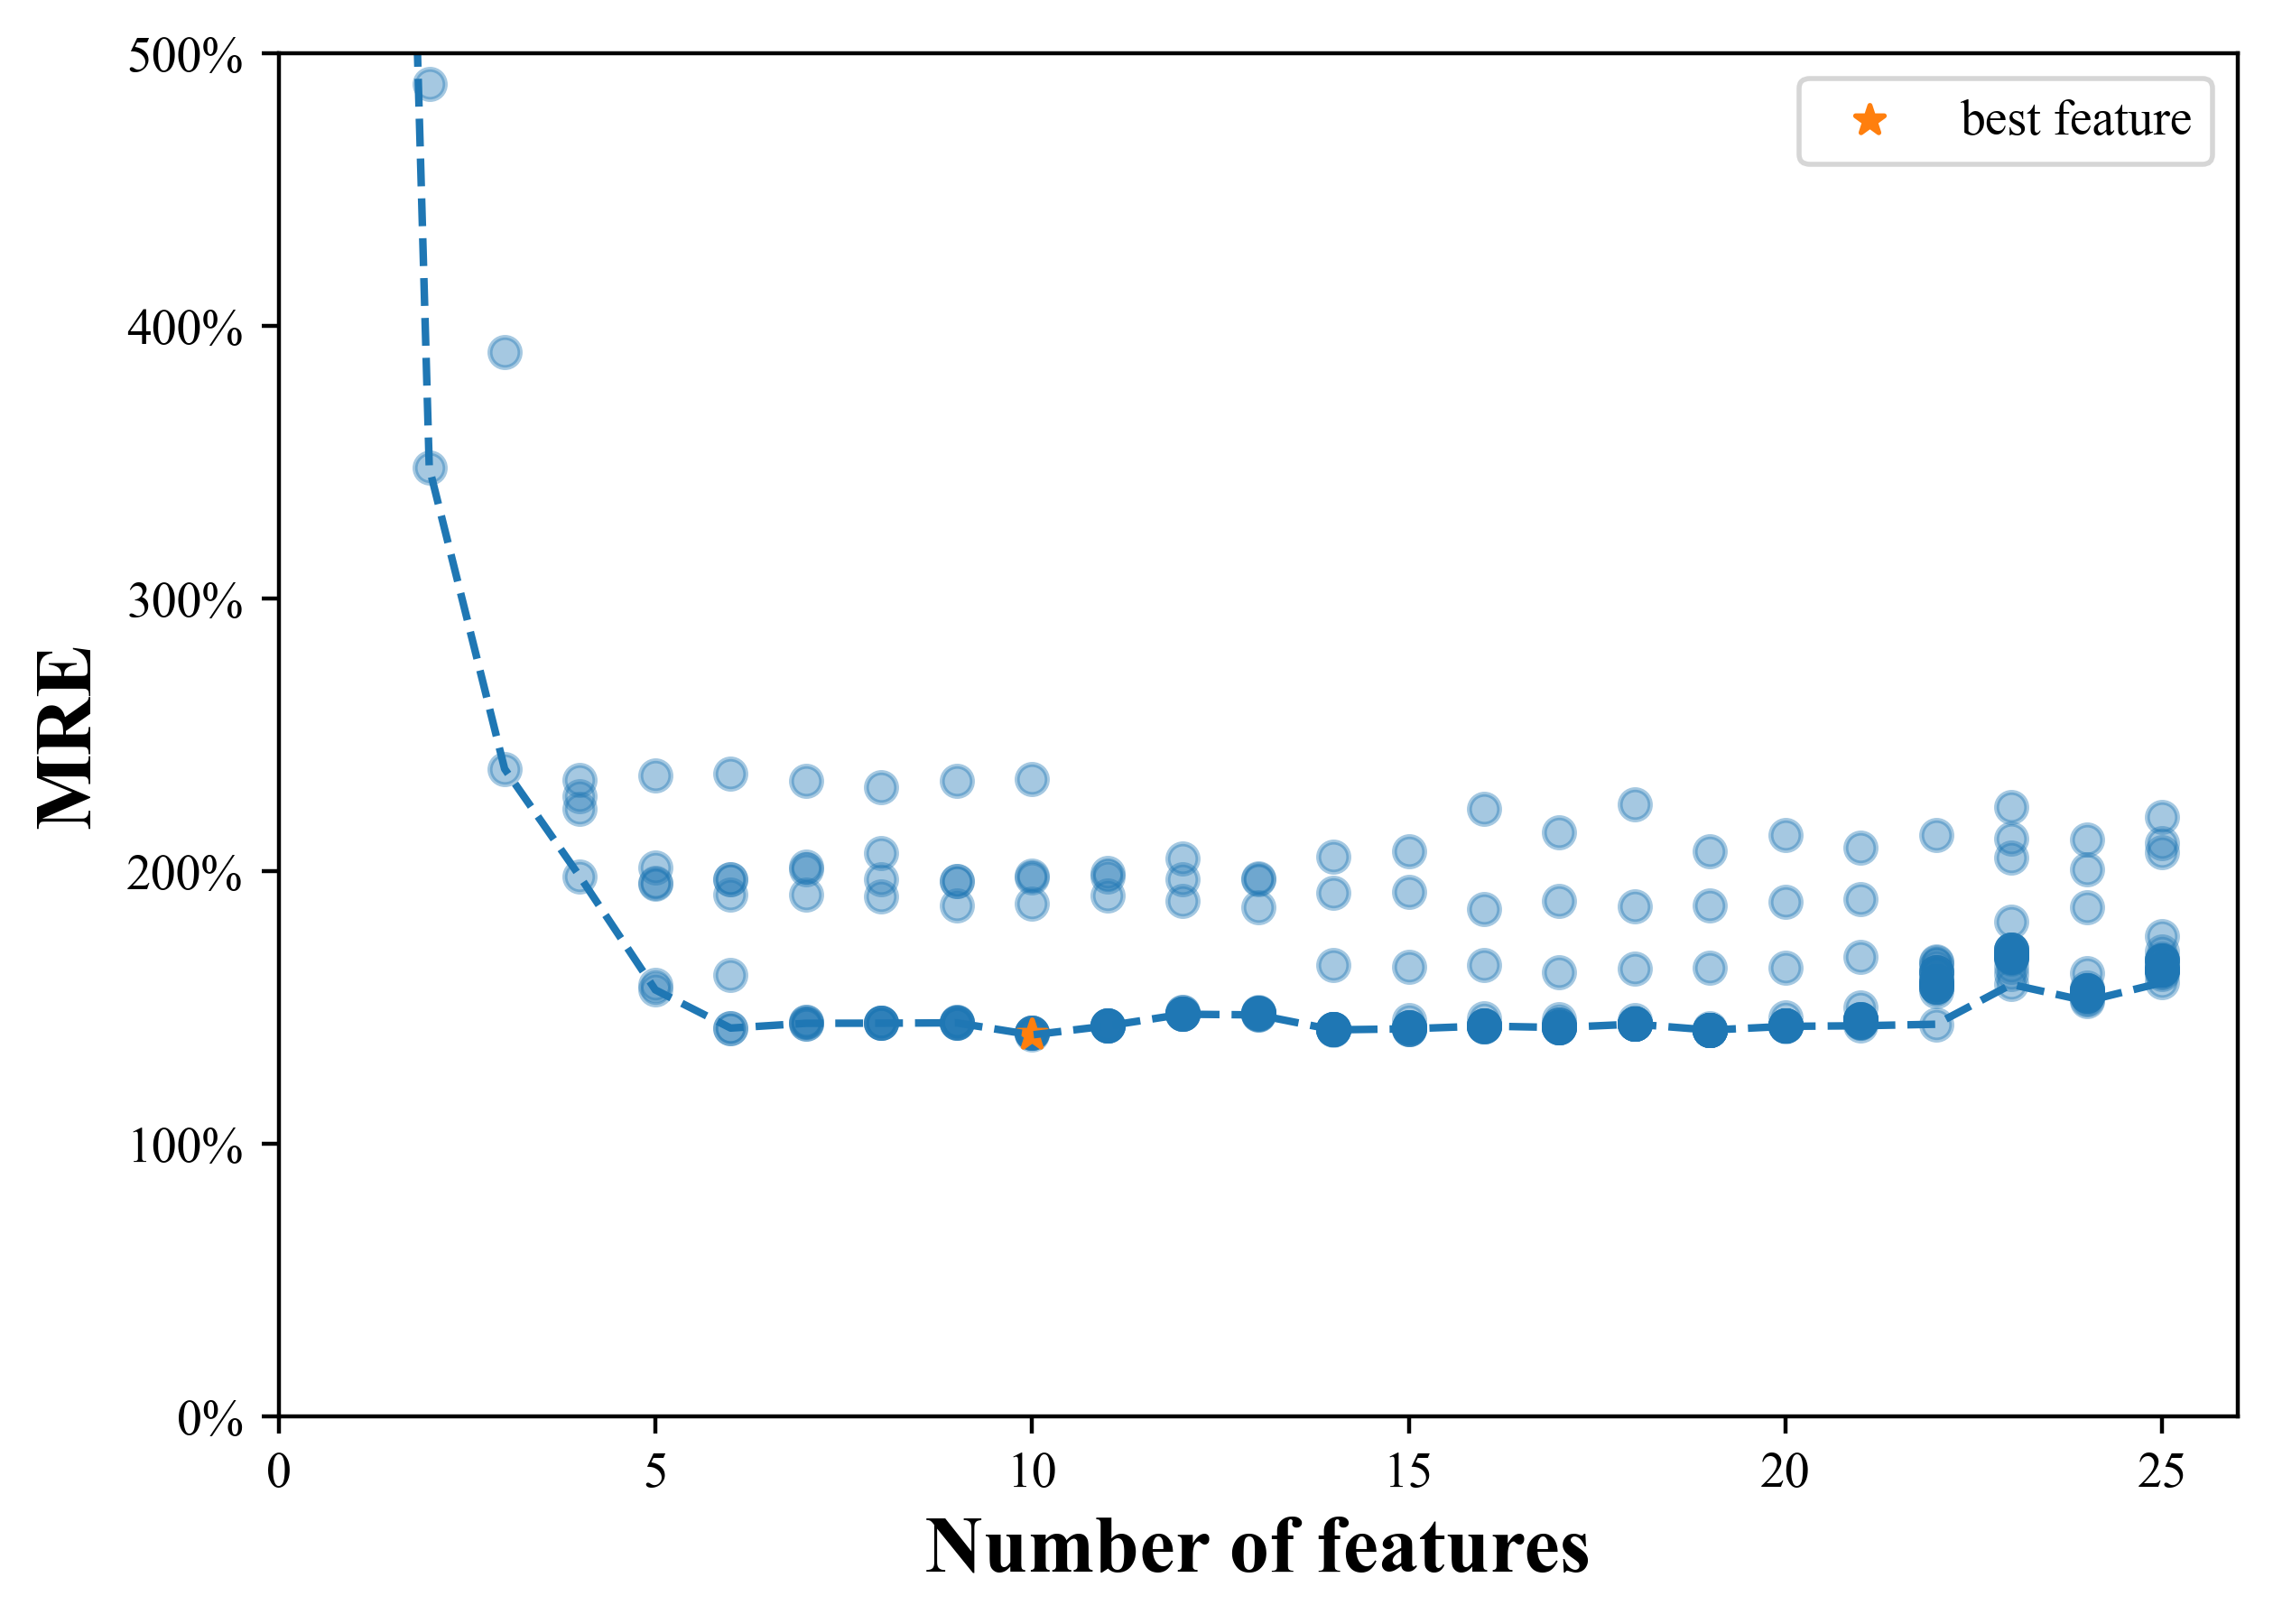

In [24]:
plt.figure(figsize=(7, 5), dpi=400)

plt.scatter(result_df_feature_selection["n_feature"],result_df_feature_selection["metric"],alpha=0.4)
plt.plot(fs_groupby["n_feature"],fs_groupby["metric"],"--")
plt.scatter([best_feature_number],fs_groupby["metric"][best_feature_number-1],label="best feature",marker="*")

from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

plt.xlabel("Number of features", fontsize=16, fontweight='bold')
plt.ylabel("MRE", fontsize=16, fontweight='bold')
plt.xlim(0, 26)  
plt.ylim(0, 5)
plt.legend()

In [25]:
# back_forward_feature_selection
def back_forward_feature_selection(model, X_train, Y_train, metric,groups_array_train):
    """
    model: instance of regressor
    X_train Y_train is dataFrame
    metric is evalucation function for feature selection 
    metric：calculate score lower score is better
    return metric for each step
    
    """
    # record result
    result_df = pd.DataFrame()
    features = X_train.columns
    best_score = 1e10
    best_features = features
    features_number = len(best_features)
    print("input features",features_number)

    for i in range(len(features) - 1):
        print("feature number",len(best_features))
        # once back and find the best features for this number of features
        best_score = 1e10
        for sub_features in itertools.combinations(best_features, features_number - 1):
            sub_features = list(sub_features)
            #print(sub_features)
#             if "groups_array_train" in agrs.keys():
            score = metric(X_train[sub_features],Y_train,groups_array_train,model)
                #print(score)
#             else:
#                 score = metric(X_train[sub_features],Y_train,model)
#             model.fit(X_train[sub_features], Y_train)
#             score = metric(Y_validation, model.predict(X_validation[sub_features]))
            df_line = pd.DataFrame(
                {"features": [",".join(sub_features)], "metric": score, "n_feature": len(sub_features)})
            result_df = result_df.append(df_line, ignore_index=True)
            if (best_score > score):
                best_score = score
                best_features = sub_features
            print(best_score)
        # for debug
        # print("best_features",best_features)
        # print("best_score",best_score)
        features_number = len(best_features)
    # find the best feature
    result_df = result_df.sort_values(by="metric", ascending=False)
    return result_df

In [33]:
best_features="TYS,Fatigue Strength,Stussi,$σ_{a}^3$,$σ_{a}^2$,$σ_{min}^{0.1}$,$σ_{min}^{1.5}$,$σ_{min}^2$,$σ_{min}^{2.5}$,$σ_{max}^{1.5}$".split(",")

### model evalucation

['TYS', 'Fatigue Strength', 'Stussi', '$σ_{a}^3$', '$σ_{a}^2$', '$σ_{min}^{0.1}$', '$σ_{min}^{1.5}$', '$σ_{min}^2$', '$σ_{min}^{2.5}$', '$σ_{max}^{1.5}$']
MRE： 1.39897827593631
样本个数  216
均方根误差RMSE  0.529
均方差MSE  0.279
平均绝对误差MAE  0.399
R2： 0.798


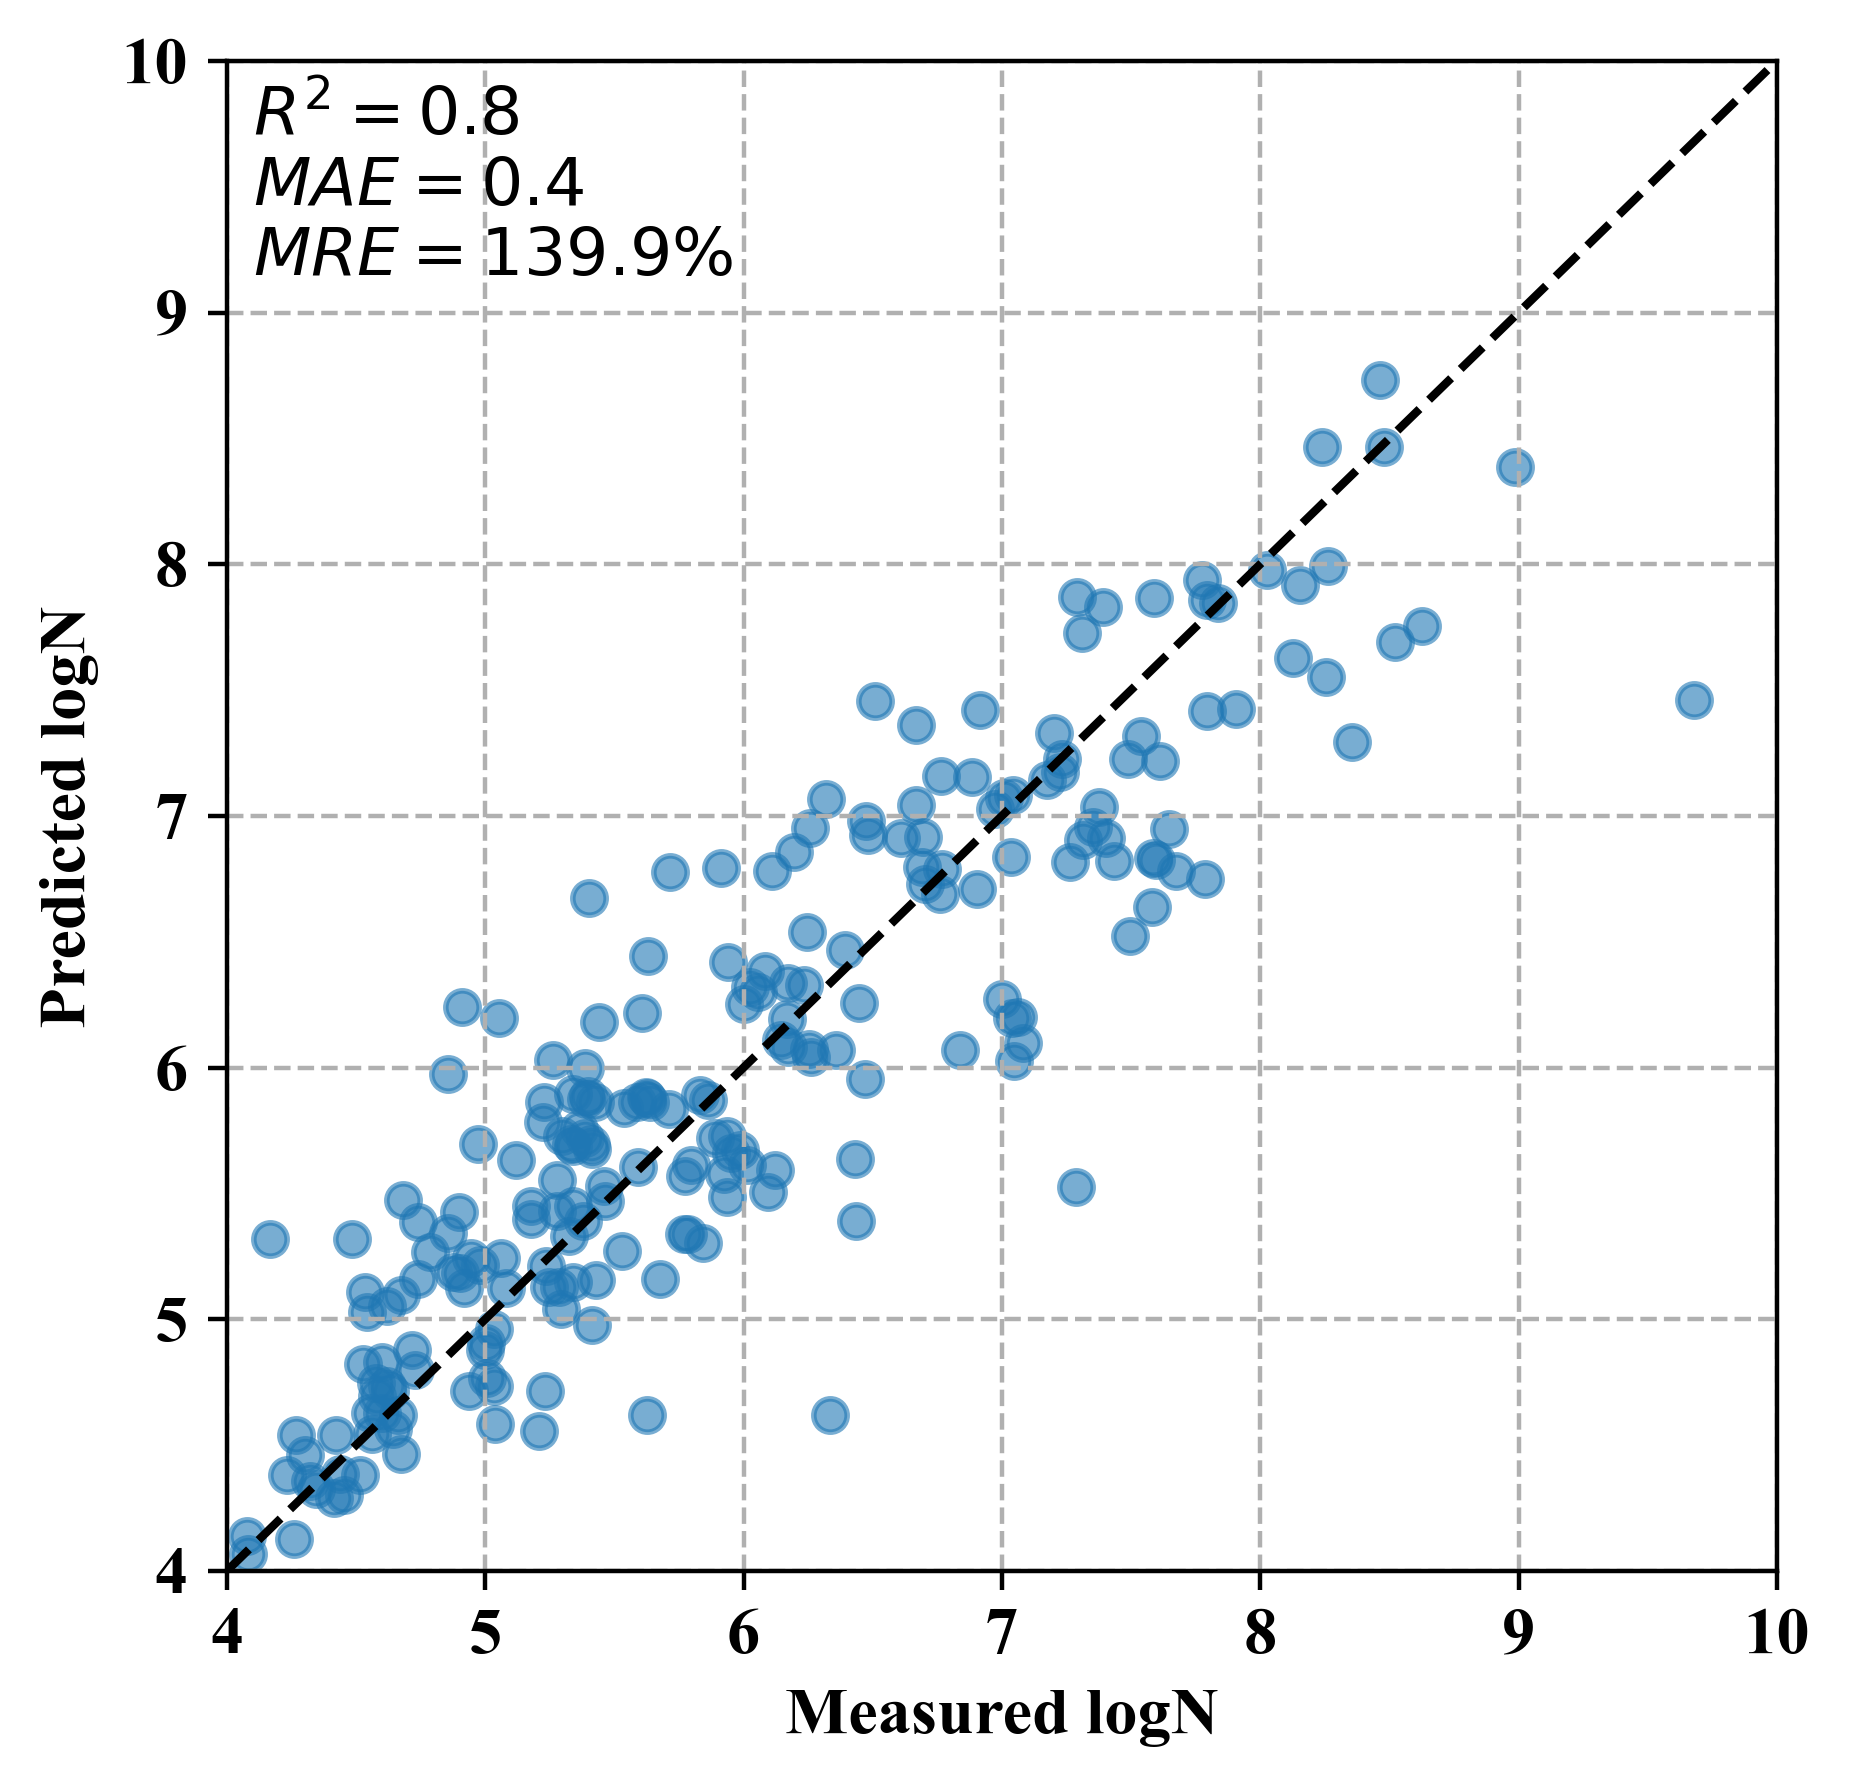

In [34]:
# setting
model_name = "S-N curve"
features = best_features
model = GradientBoostingRegressor(random_state=0)
plt.rc('font',family='Times New Roman',size=12)
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
y_predict_list = []
y_true_list = []
index_list = []

x = df_train[features].values
y = df_train["LgN"].values
groups_array = df_train["S-N_index"]
#x = df_curve[X_columns].values
print(features)
for train_index, test_index in logo.split(x, y, groups_array):# 根据合金的名称将其分组
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    
    
    #model = Linear_SVR()
    #model = LinearRegression()
    model.fit(X_train,Y_train)
    
    y_predict_list.extend(model.predict(X_test))
    y_true_list.extend(Y_test)
    index_list.extend(index[test_index])
# calculate mre
mre = mean_relative_error(np.power(10,y_true_list), np.power(10,y_predict_list))
print("MRE：",mre)

evalucation_matrix = evaluate_model_plot(y_true_list,y_predict_list,show=False)

# true
y_true = y_true_list
y_predict = y_predict_list
plt.figure(figsize=(5, 5), dpi=400)
plt.rcParams['font.sans-serif'] = ['Arial']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
plt.grid(linestyle="--")  # 设置背景网格线为虚线
ax = plt.gca()  # 获取坐标轴对象
plt.scatter(y_true, y_predict,alpha=0.6)
plt.plot([4, 10], [4, 10], color='black',linestyle="--")

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("Measured logN", fontsize=12, fontweight='bold')
plt.ylabel("Predicted logN", fontsize=12, fontweight='bold')
plt.xlim(4, 10)  # 设置x轴的范围
plt.ylim(4, 10)
plt.text(4.1,9.15,"$R^2={r2}$\n$MAE={MAE}$\n$MRE={MRE}\%$".format(r2=round(evalucation_matrix["R2"],2)
                                                                ,MAE=round(evalucation_matrix["MAE"],2)
                                                                ,MRE=round(mre*100,1)
                                                              ))
plt.savefig(f'./sn_evaluation_{model_name}.svg', format='svg')
plt.show()

In [35]:
# testing set
test_index = [4,6,9,15,18,21,41]
df_test = pd.DataFrame()
for test_curve in test_index:
    df_test = df_test.append(df_curve[df_curve["S-N_index"]==test_curve])
df_test["S-N_index"].unique()

features = best_features

y_predict_list = []
y_true_list = []
index_list = []
X_train, X_test = df_train[features], df_test[features]
Y_train, Y_test = df_train[Y_column], df_test[Y_column]
model = GradientBoostingRegressor(random_state=0)
model.fit(X_train[features],Y_train)
y_predict_list.extend(model.predict(X_test[features]))
y_true_list.extend(Y_test)
index_list.extend(df_test["S-N_index"])
# 相对误差
mre = fatigue_mre_metric(y_true_list, y_predict_list)
print("MRE:",mre)
# 
#features = df_curve.drop(["S-N_index","LgN"],axis=1).columns
# feature_importance = model.feature_importances_
# draw_feature_importance(features,feature_importance)

MRE: 1.0535702056261531


In [48]:
dataset_SN.columns = ["$σ_{a}$"  if i=="S" else i for i in dataset_SN.columns]

<Figure size 432x288 with 0 Axes>

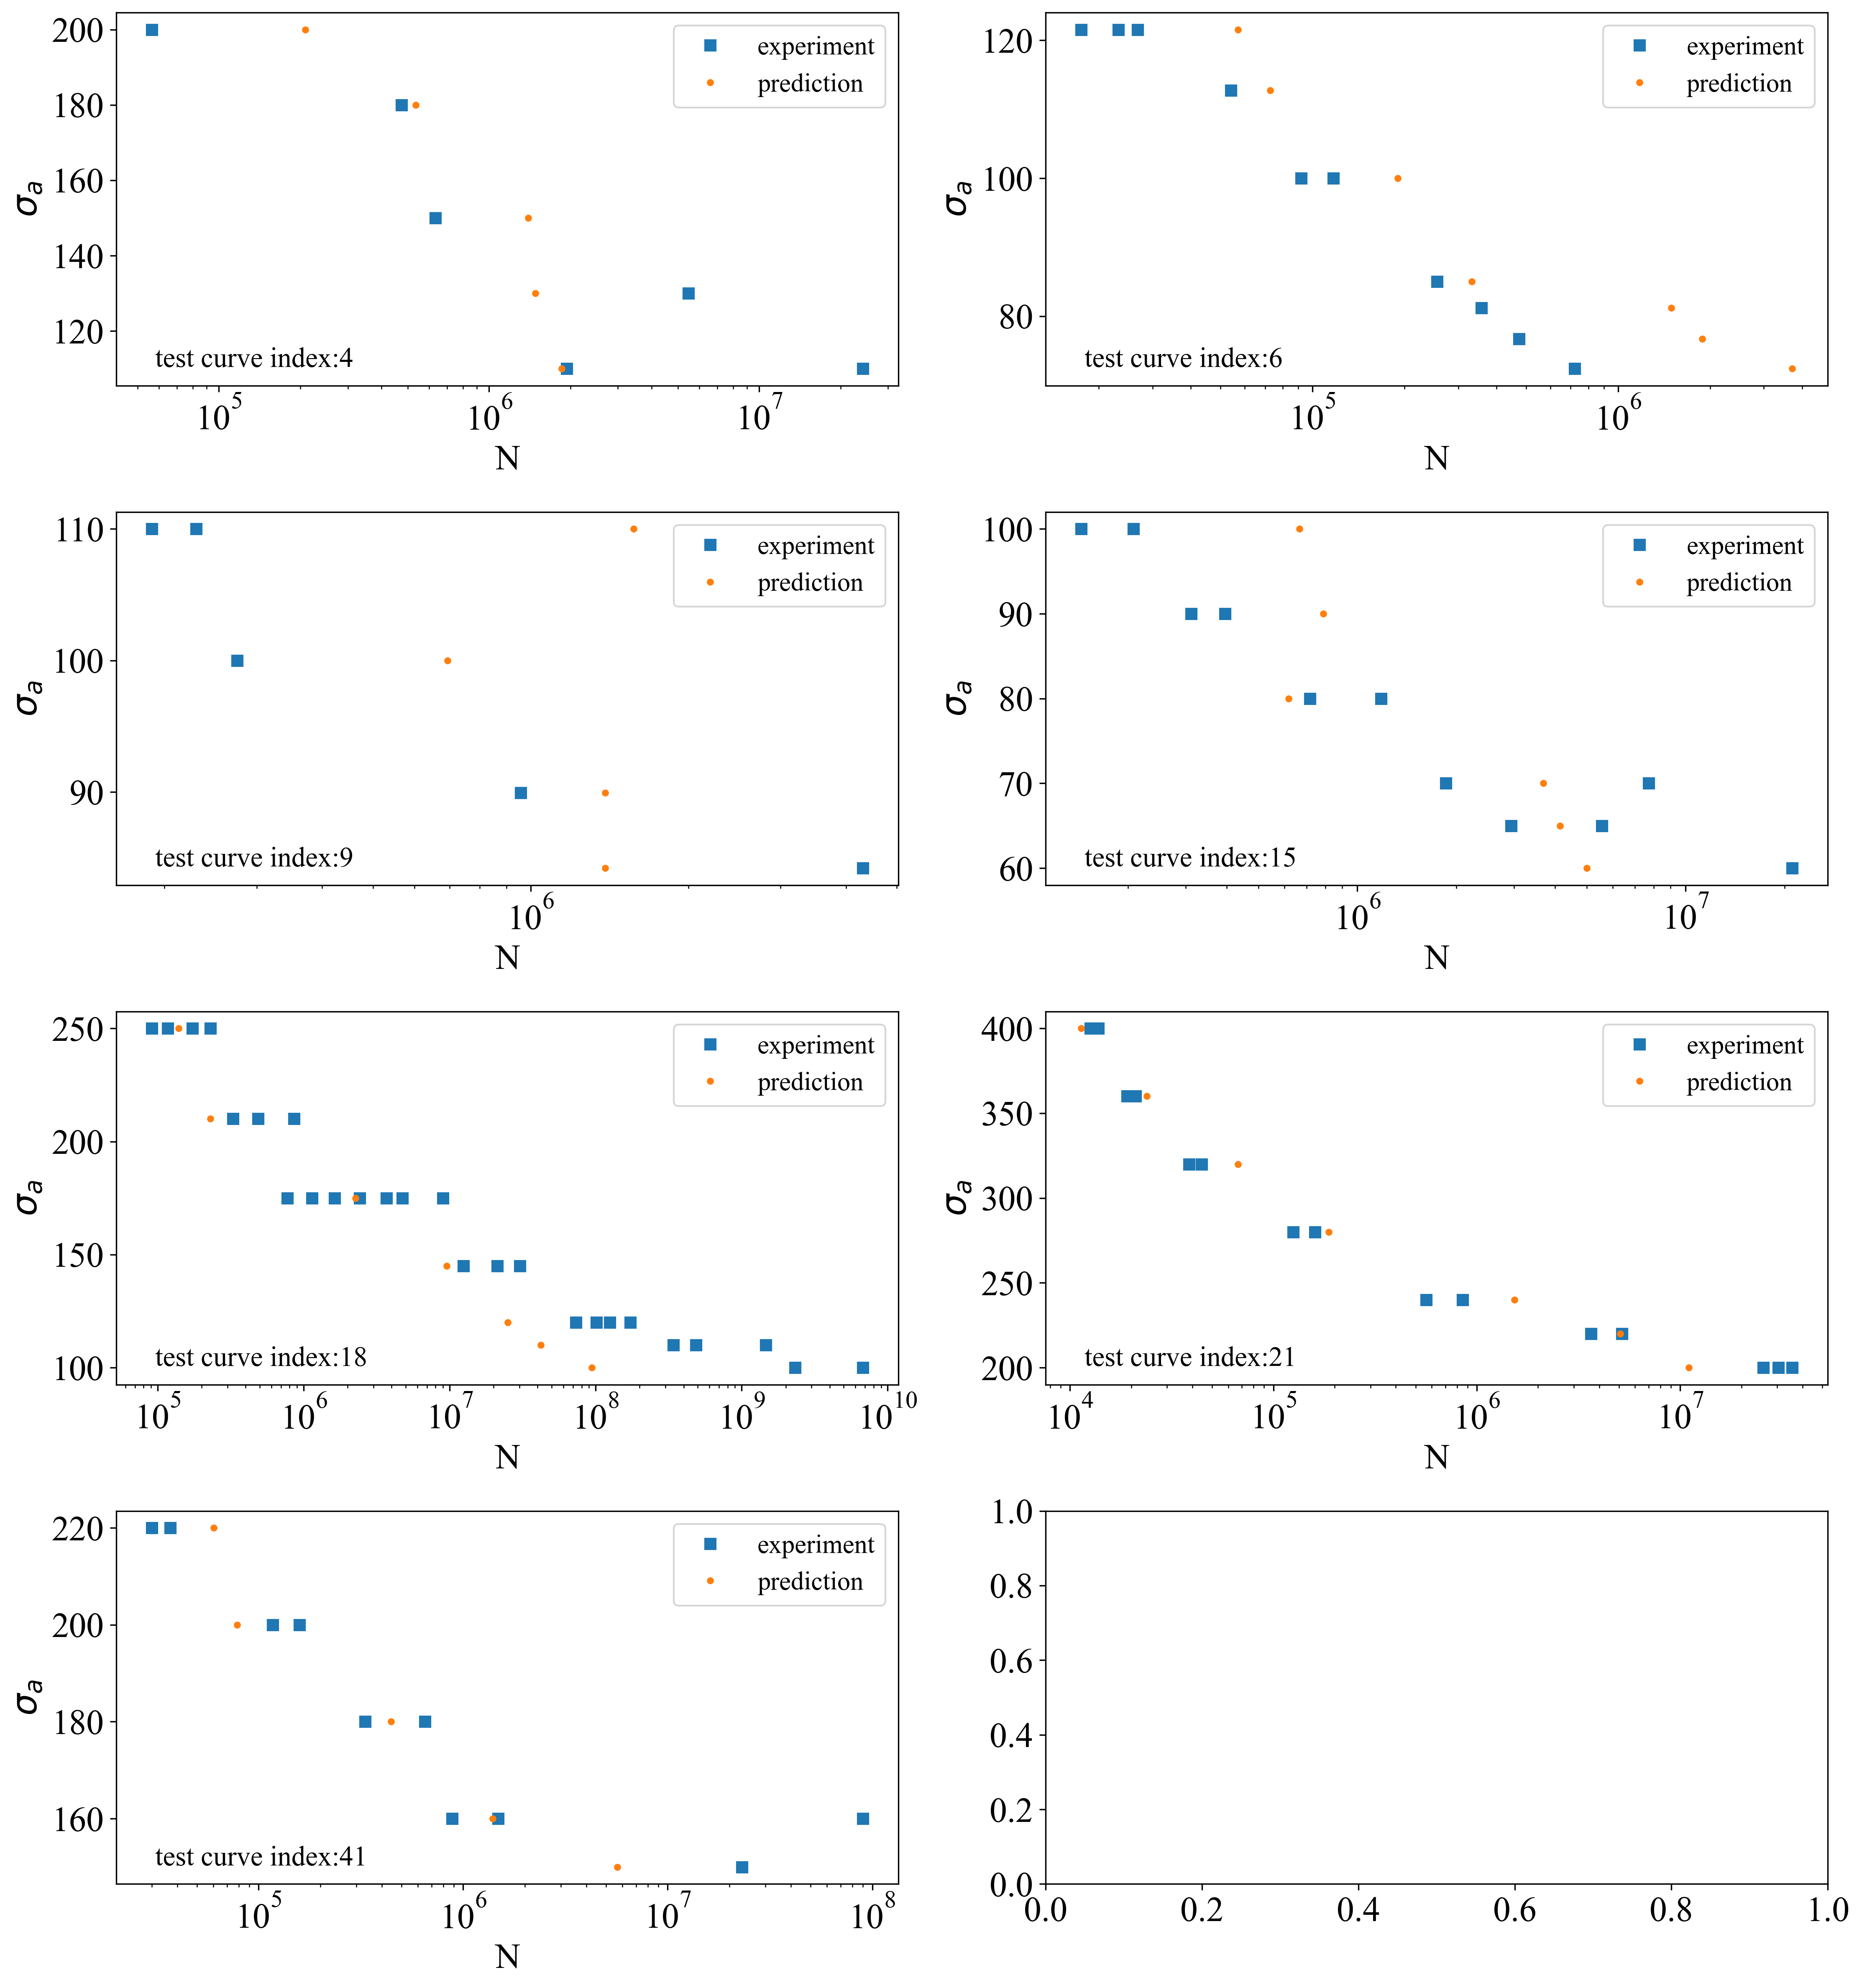

In [59]:
test_index = [4,6,9,15,18,21,41]
#误差可视化
result_df = pd.DataFrame({"S-N_index":index_list,"y_true":y_true_list,"y_predict":y_predict_list})
plt.subplots_adjust(hspace=0.5,wspace=0.5)
row = 4
col = 2

fig, axes = plt.subplots(row,col, figsize=(15, row*4)
                         ,dpi=300)
plt.xticks(fontsize=12)
for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if(i<len(list(test_index))):
        # 数据准备
        draw_index = test_index[i]
        every_test_curve = df_curve.loc[df_curve["S-N_index"]==draw_index,:]
        test_sn = dataset_SN.loc[dataset_SN["S-N_index"]==draw_index,:]
        df_test_ml = pd.merge(dataset_main, test_sn, how='inner')
        # 实验数据
        ax.semilogx(df_test_ml["N"],df_test_ml["$σ_{a}$"],'.',Marker='s',label="experiment")
        # predict
        every_test_curve["y_pred"] = list(result_df.loc[result_df["S-N_index"]==draw_index,"y_predict"])
        every_test_curve["y_pred_N"] = every_test_curve.loc[:,"y_pred"].apply(lambda x:pow(10,x))
      
        # draw S-N curve in ax
        ax.semilogx(every_test_curve["y_pred_N"],every_test_curve["$σ_{a}$"],'.',Marker='.',label="prediction")
        # annotation
        ax.set_ylabel("$σ_{a}$",fontsize=20)
        ax.set_xlabel("N",fontsize=20)
        ax.text(0.05, 0.05, "test curve index:"+str(draw_index),transform=ax.transAxes, color='black',fontsize=16)
        ax.legend(fontsize=15)
fig.tight_layout()

<Figure size 3000x3000 with 0 Axes>

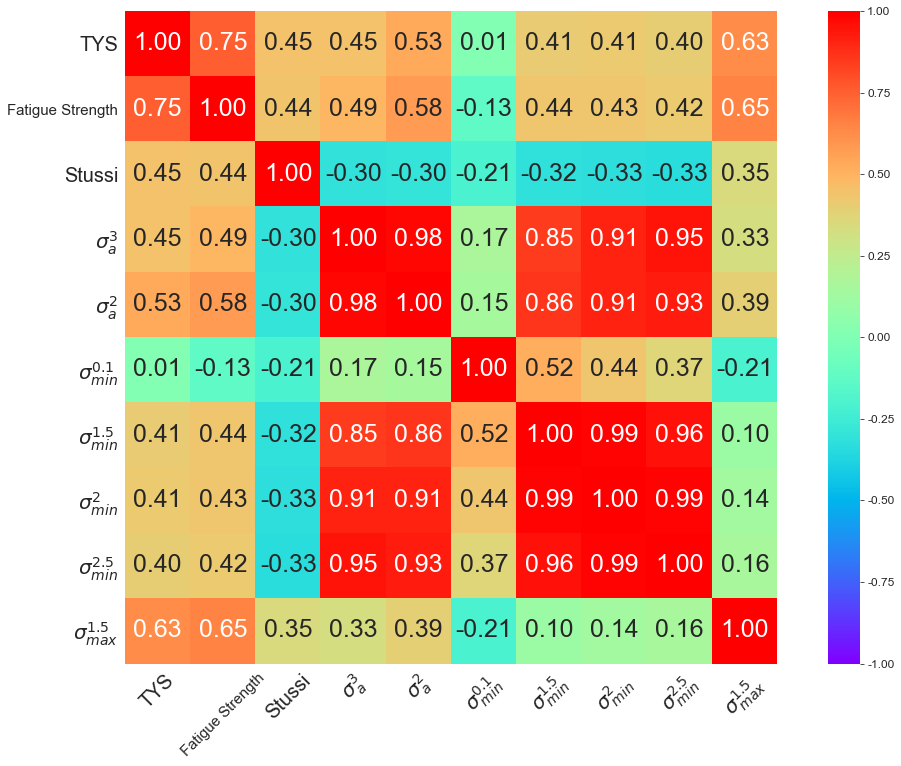

In [54]:
plt.figure(figsize=(10, 10), dpi=300)
cor = df_curve[best_features].corr()
mask = np.zeros_like(cor)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18,12))
    ax = sns.heatmap(cor, annot=True,annot_kws={"size": 25},fmt=".2f",
                     cmap="rainbow",linewidths=0,vmin=-1,vmax=1,mask=mask, square=True)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    i = 0
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        i=i+1
        if i == 2:
            tick.set_fontsize('15')
        #tick.set_fontweight()
    i = 0
    for tick in ax.get_yticklabels():
        i=i+1
        if i == 2:
            tick.set_fontsize('15')
        #tick.set_fontweight()
    
    fig = ax.get_figure()
    fig.savefig("heatmap.svg", dpi=300)

### shap

In [60]:
import shap

In [61]:
explainer = shap.TreeExplainer(model,feature_perturbation="tree_path_dependent")

In [62]:
X = df_curve[best_features]

In [63]:
shap_values = explainer.shap_values(X)

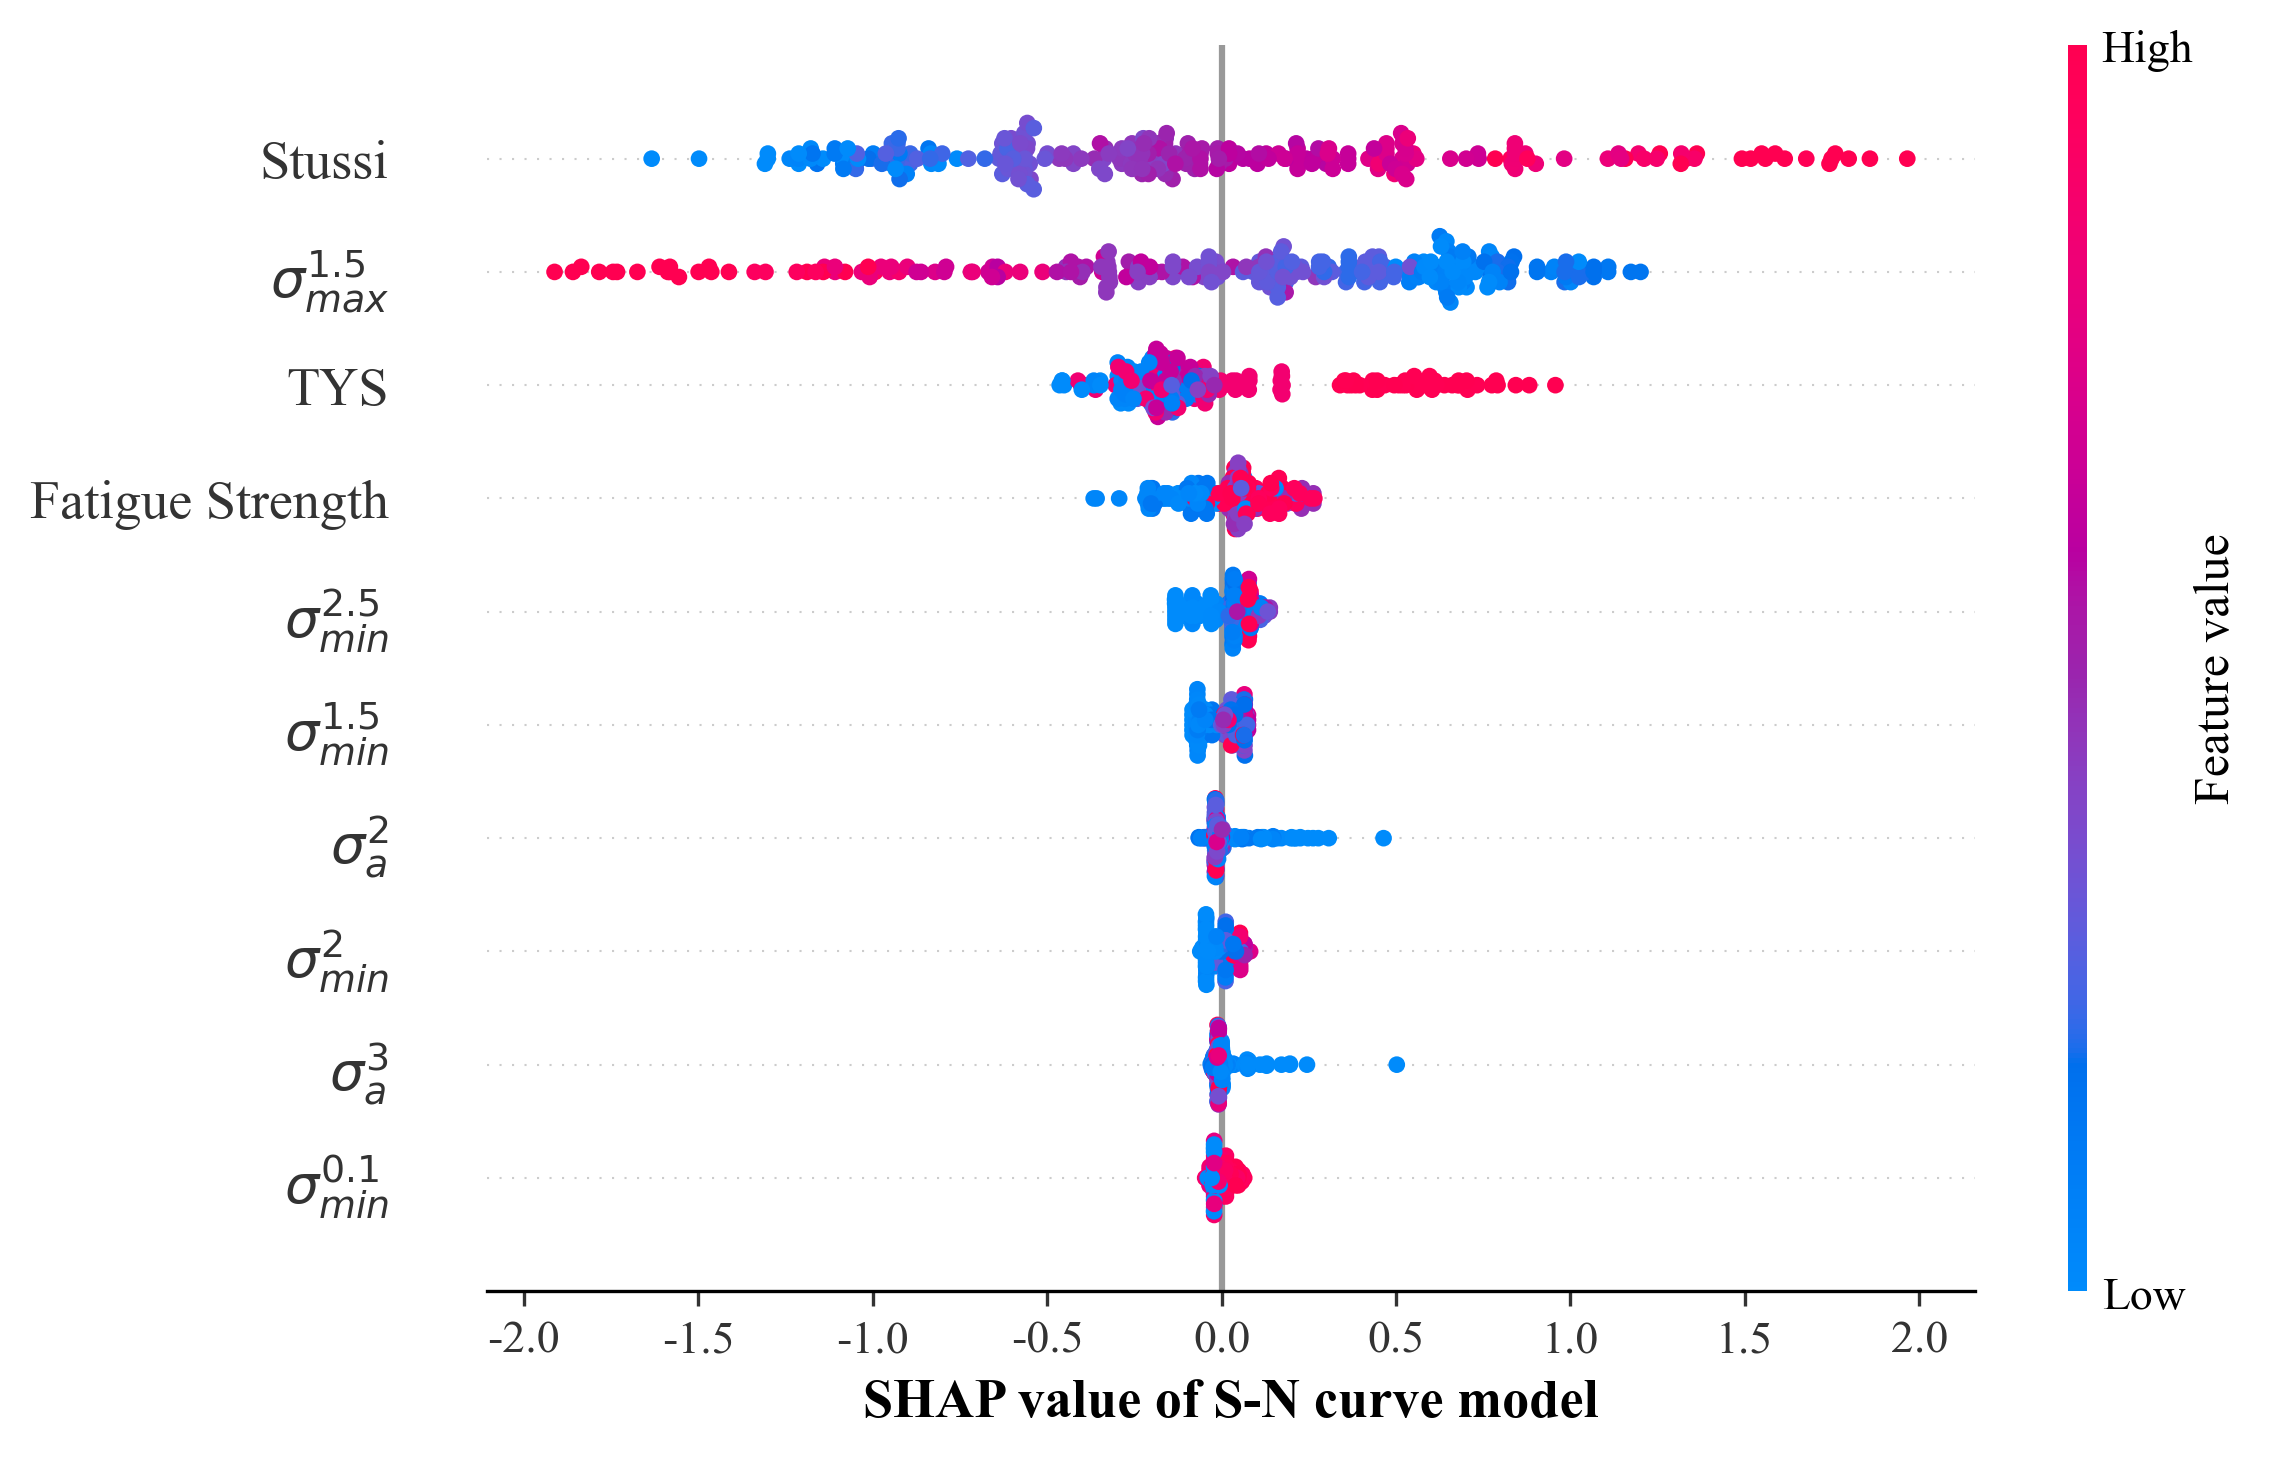

In [64]:
plt.figure(figsize=(5, 10),dpi=300)         
shap.summary_plot(shap_values, X,show=False)
plt.xlabel("SHAP value of S-N curve model" , fontweight='bold')
#plt.rcParams['figure.figsize'] = (8.0, 12.0)
plt.savefig('./SN_shap.png')
plt.show()


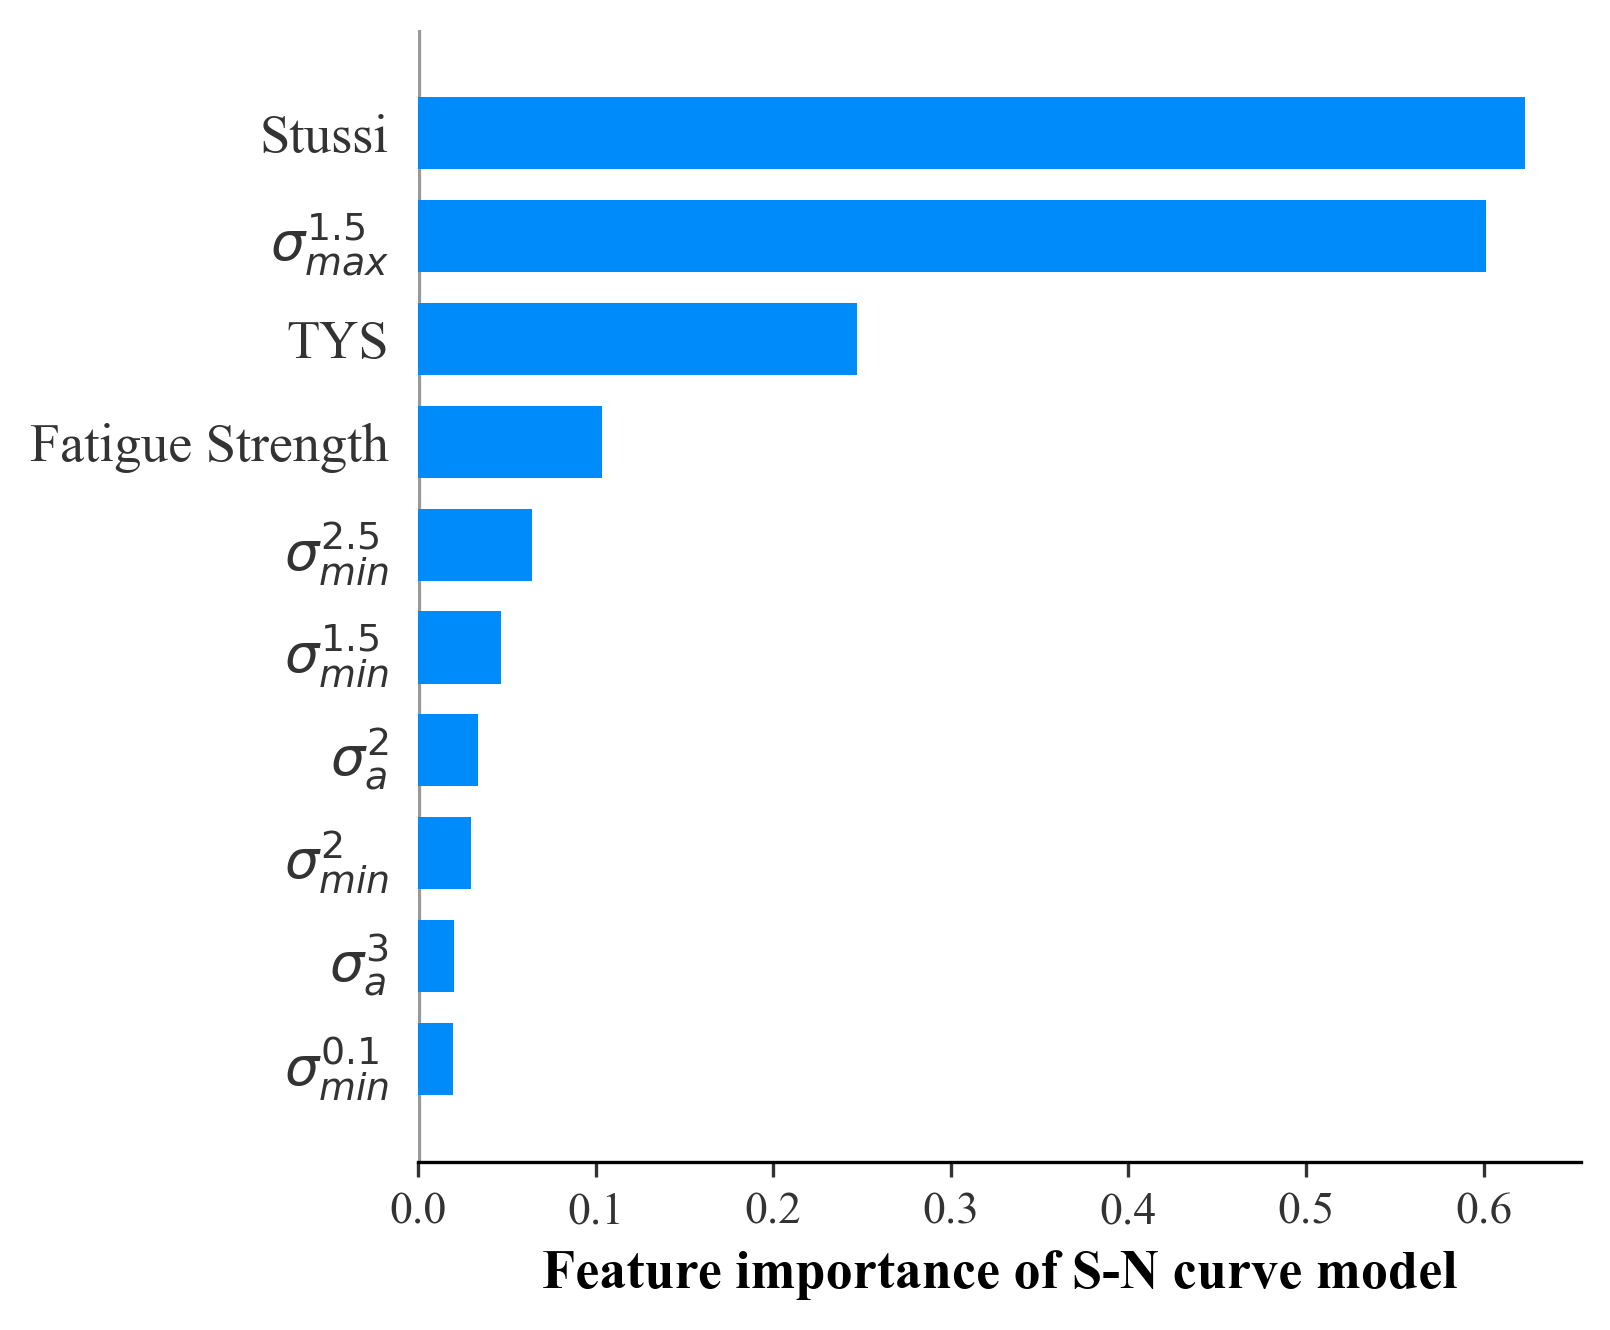

In [65]:
plt.figure(figsize=(5, 10),dpi=300)
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.xlabel(f"Feature importance of {model_name} model" , fontweight='bold')
plt.savefig(f'./SN_feature_importance_{model_name}.png')
plt.show()

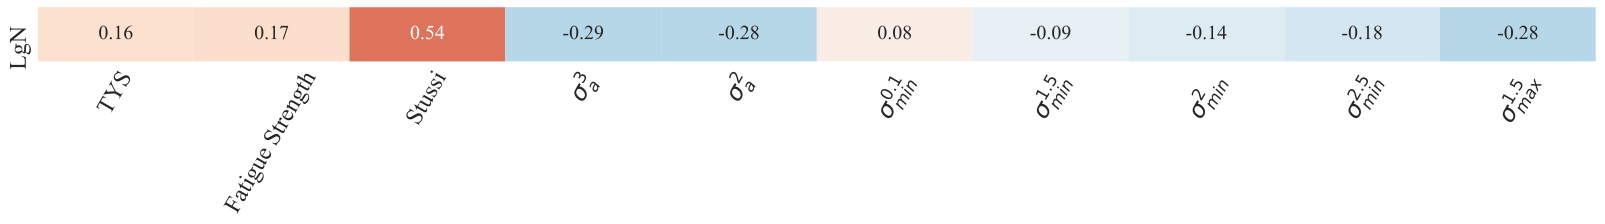

In [66]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
cor = df_curve.corr()
#mask = np.zeros_like(cor["LgN"]).reshape(1,28)
with sns.axes_style("white"):
    plt.rc('font',family='Times New Roman',size=24)
    #plt.figure(figsize=(10, 10), dpi=1000)
    f, ax = plt.subplots(figsize=(28,1))
    ax = sns.heatmap(cor.loc[["LgN"],best_features], annot=True,annot_kws={"size": 20},fmt=".2f",
                     cmap=plt.cm.RdBu_r 
                     #
                     ,cbar=False,
                     linewidths=0,vmin=-1,vmax=1#,mask=mask
                    )
    plt.xticks(rotation=60)
    plt.savefig("corr.png",dpi=600,bbox_inches="tight")


In [67]:
cor.loc[["LgN"],features]

TYS  Fatigue Strength    Stussi  $σ_{a}^3$  $σ_{a}^2$  \
LgN  0.163594          0.172205  0.541953  -0.285316  -0.282065   

     $σ_{min}^{0.1}$  $σ_{min}^{1.5}$  $σ_{min}^2$  $σ_{min}^{2.5}$  \
LgN         0.076388        -0.085712    -0.139666        -0.179871   

     $σ_{max}^{1.5}$  
LgN        -0.282604

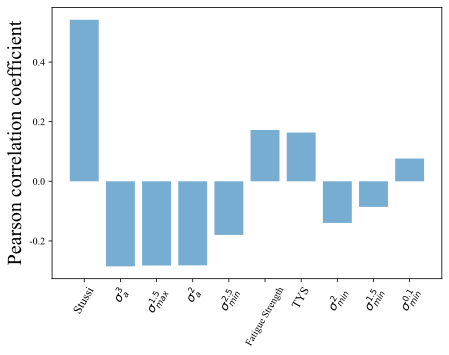

In [68]:
features = best_features
%matplotlib inline
plt.rc('font',family='Times New Roman')
bar_x = features
bar_y = cor.loc["LgN",features].values
bar_x_sorted = np.array(features)[np.argsort(abs(bar_y))][::-1]
bar_y_sorted = np.array(bar_y)[np.argsort(abs(bar_y))][::-1]
fig, ax = plt.subplots(figsize=(7,5),dpi=300)
ax.bar(bar_x_sorted,bar_y_sorted,alpha=0.6,data=True)
ax.set_ylabel("Pearson correlation coefficient",fontsize=20)
#ax.set_xtick(fontsize=12)
for size in ax.get_xticklabels():   #获取x轴上所有坐标，并设置字号
    #print(str(size))
    size.set_fontname('Times New Roman')
i = 0
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
    tick.set_fontsize('12')
    i=i+1
    if i ==6:
        tick.set_fontsize('10')
        #tick.set_fontweight("bold")

plt.savefig("corr_bar.png",dpi=600,bbox_inches="tight")
plt.show()

## model insight

### shap dependent plot

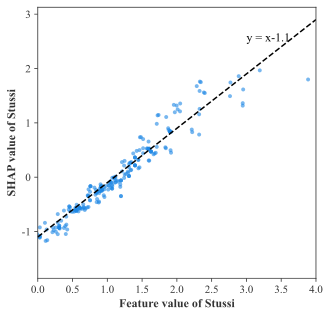

In [403]:
font1 = {'weight': 'bold',
         'size': 12}
plt.rc('font',family='Times New Roman',size=12)
fig,ax = plt.subplots(dpi=300,figsize=(5,5))
ax.plot([0,4],[-1.1,2.9],"k--")
ax.annotate('y = x-1.1', xy=(2,1), xytext=(3,2.5))
shap.dependence_plot("Stussi", shap_values, X,interaction_index=None,xmin=0,xmax=4,ax=ax,show=False,alpha=0.6)
ax.set_xlabel("Feature value of Stussi",font1)
ax.set_ylabel("SHAP value of Stussi",font1)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

plt.savefig("pdp_Stussi.png",dpi=600,bbox_inches="tight")
plt.show()

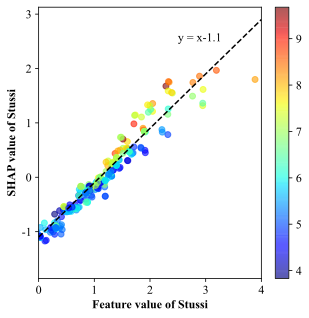

In [419]:
fig,ax = plt.subplots(dpi=400,figsize=(5,5))
c = Y.values
#plt.figure(figsize=(8, 5), dpi=120)
#plt.scatter(data[:, 0], data[:, 1], )
#
plt.scatter(X[best_features[2]],shap_values[:,2],c=c, marker='o', cmap='jet',alpha=0.6)
ax.plot([0,4],[-1.1,2.9],"k--")
ax.annotate('y = x-1.1', xy=(2,1), xytext=(2.5,2.5))
# ax.plot([0,14000],[1,-2.2],"k--")
# k = round(3.2/14000,5)
#ax.annotate(f'y = -{k}x-1.1', xy=(2,1), xytext=(3,1.1))
ax.set_xlabel("Feature value of Stussi",font1)
ax.set_ylabel("SHAP value of Stussi",font1)
ax.set_xlim(0,4)
plt.colorbar()
plt.savefig("pdp_Stussi.png",dpi=600,bbox_inches="tight")
plt.show()

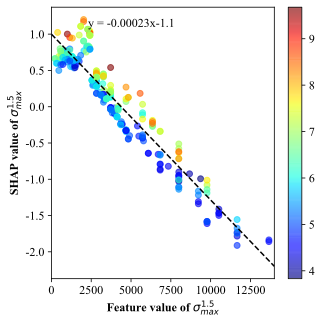

In [420]:
fig,ax = plt.subplots(dpi=400,figsize=(5,5))
c = Y.values

plt.scatter(X[best_features[9]],shap_values[:,9],c=c, marker='o', cmap='jet',alpha=0.6)
ax.plot([0,14000],[1,-2.2],"k--")
k = round(3.2/14000,5)
ax.annotate(f'y = -{k}x-1.1', xy=(2,1), xytext=(2300,1.1))
ax.set_xlabel("Feature value of $σ_{max}^{1.5}$",font1)
ax.set_ylabel("SHAP value of $σ_{max}^{1.5}$",font1)
ax.set_xlim(0,14000)
plt.colorbar()
plt.savefig("pdp_σ_{max}.png",dpi=600,bbox_inches="tight")
plt.show()


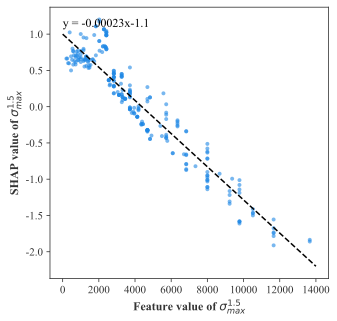

In [312]:
fig,ax = plt.subplots(dpi=300,figsize=(5,5))
#ax.set_xlabel("feature value of TYS")
ax.plot([0,14000],[1,-2.2],"k--")
k = round(3.2/14000,5)
ax.annotate(f'y = -{k}x-1.1', xy=(2,1), xytext=(3,1.1))
shap.dependence_plot("$σ_{max}^{1.5}$", shap_values, X,interaction_index=None,ax=ax,show=False,alpha=0.6)
ax.set_xlabel("Feature value of $σ_{max}^{1.5}$",font1)
ax.set_ylabel("SHAP value of $σ_{max}^{1.5}$",font1)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.savefig("pdp_σ_{max}.png",dpi=600,bbox_inches="tight")
plt.show()

### partial dependent plot

In [83]:
def feature_generation(df_curve):
    """
    generate features from source dataset
    """
    df_curve["LogS"]=df_curve["S"].apply(np.log10)
    df_curve["Stussi"] = (df_curve["UTS"]-df_curve["S"])/(df_curve["S"]-df_curve["Fatigue Strength"]+100)
    df_curve["Stussi"] = df_curve["Stussi"].apply(np.log)
    # S
    df_curve["$∆σ^3$"]=df_curve["S"]*df_curve["S"]*df_curve["S"]
    df_curve["$∆σ^2$"]=df_curve["S"]*df_curve["S"]
    df_curve["$∆σ^{0.5}$"]=df_curve["S"].apply(np.sqrt)
    #df_curve["$∆σ^{0.3}$"]=df_curve["S"].apply(lambda x: np.power(x,0.3))
    df_curve["$∆σ^{0.1}$"]=df_curve["S"].apply(lambda x: np.power(x,0.1))


    Smin = "$σ_{min}$"
    Smax = "$σ_{max}$"
    Savg = "$σ_{m}$"
    df_curve[Smax] = 2*df_curve["S"]/(1-df_curve["R"])
    df_curve[Smin] = df_curve[Smax]*df_curve["R"]
    df_curve[Savg] = (np.abs(df_curve[Smin])+np.abs(df_curve[Smax]))/2
    # Smin
    df_curve["$σ_{min}^{0.1}$"]=abs(df_curve[Smin]).apply(lambda x: np.power(x,0.1))
    #df_curve["$σ_{min}^{0.3}$"]=abs(df_curve[Smin]).apply(lambda x: np.power(x,0.3))
    df_curve["$σ_{min}^{0.5}$"]=abs(df_curve[Smin]).apply(np.sqrt)
    df_curve["$σ_{min}^{1.5}$"]=abs(df_curve[Smin]).apply(lambda x: np.power(x,1.5))
    df_curve["$σ_{min}^2$"]=df_curve[Smin].apply(lambda x: np.power(x,2))
    df_curve["$σ_{min}^{2.5}$"]=abs(df_curve[Smin]).apply(lambda x: np.power(x,2.5))
    df_curve["$σ_{min}^3$"]=df_curve[Smin].apply(lambda x: np.power(x,3))

    df_curve["$σ_{max}^{0.1}$"]=abs(df_curve[Smax]).apply(lambda x: np.power(x,0.1))
    #df_curve["$σ_{max}^{0.3}$"]=abs(df_curve[Smax]).apply(lambda x: np.power(x,0.3))                                             
    df_curve["$σ_{max}^{0.5}$"]=abs(df_curve[Smax]).apply(np.sqrt)
    df_curve["$σ_{max}^{1.5}$"]=abs(df_curve[Smax]).apply(lambda x: np.power(x,1.5))
    df_curve["$σ_{max}^2$"]=df_curve[Smax]*df_curve[Smax]
    df_curve["$σ_{max}^{2.5}$"]=abs(df_curve[Smax]).apply(lambda x: np.power(x,2.5))
    df_curve["$σ_{max}^3$"]=df_curve[Smax]*df_curve[Smax]*df_curve[Smax]
    return df_curve
    

#### R

In [103]:
#list_R = sorted(list(df_curve["R"].unique()))
list_R = sorted(list([-2.0,-1.0,0.1,0.5]))
list_R
# 生成笛卡尔积
df_sencity = df_all[coulumns].groupby(["S-N_index","UTS","TYS","R","S","Fatigue Strength"],as_index=False).mean()
df1 = df_sencity[df_sencity["S-N_index"]==21][["S-N_index","UTS","TYS","S","Fatigue Strength"]]
#df1 = df_sencity[["S-N_index","UTS","TYS","S","Fatigue Strength"]]
df2 = pd.DataFrame({"R":list_R})
def product_df(df1,df2):
    df1["key"]=1
    df2["key"]=1
    df_merged = pd.merge(df1,df2,on='key')
    del df_merged["key"]
    return df_merged
df_merged = product_df(df1,df2)
df_merged.head()

S-N_index  UTS  TYS      S  Fatigue Strength    R
0         21  600  531  200.0        194.805503 -2.0
1         21  600  531  200.0        194.805503 -1.0
2         21  600  531  200.0        194.805503  0.1
3         21  600  531  200.0        194.805503  0.5
4         21  600  531  220.0        194.805503 -2.0

In [104]:
virtual_data = feature_generation(df_merged)[features]
virtual_data["predict"] = model.predict(virtual_data.values)
virtual_data["R"] = df_merged["R"]
virtual_data["S"] = df_merged["S"]
virtual_data.head()

TYS  Fatigue Strength    Stussi      $∆σ^3$   $∆σ^2$  $σ_{min}^{0.1}$  \
0  531        194.805503  1.335654   8000000.0  40000.0         1.748223   
1  531        194.805503  1.335654   8000000.0  40000.0         1.698646   
2  531        194.805503  1.335654   8000000.0  40000.0         1.461443   
3  531        194.805503  1.335654   8000000.0  40000.0         1.820564   
4  531        194.805503  1.110303  10648000.0  48400.0         1.764965   

   $σ_{min}^{1.5}$    $σ_{min}^2$  $σ_{min}^{2.5}$  $σ_{max}^{1.5}$   predict  \
0      4354.648432   71111.111111     1.161240e+06      1539.600718  7.829023   
1      2828.427125   40000.000000     5.656854e+05      2828.427125  7.041921   
2       296.296296    1975.308642     1.316872e+04      9369.711586  4.450647   
3      8000.000000  160000.000000     3.200000e+06     22627.416998  4.533893   
4      5023.913186   86044.444444     1.473681e+06      1776.221541  7.521048   

     R      S  
0 -2.0  200.0  
1 -1.0  200.0  
2  0.1  200.0  
3  0.5  200.0  
4 -2.0  220.0

In [105]:
df_plot = virtual_data.groupby(["S","R"],as_index=False).mean()
df_plot.head()

S    R  TYS  Fatigue Strength    Stussi      $∆σ^3$   $∆σ^2$  \
0  200.0 -2.0  531        194.805503  1.335654   8000000.0  40000.0   
1  200.0 -1.0  531        194.805503  1.335654   8000000.0  40000.0   
2  200.0  0.1  531        194.805503  1.335654   8000000.0  40000.0   
3  200.0  0.5  531        194.805503  1.335654   8000000.0  40000.0   
4  220.0 -2.0  531        194.805503  1.110303  10648000.0  48400.0   

   $σ_{min}^{0.1}$  $σ_{min}^{1.5}$    $σ_{min}^2$  $σ_{min}^{2.5}$  \
0         1.748223      4354.648432   71111.111111     1.161240e+06   
1         1.698646      2828.427125   40000.000000     5.656854e+05   
2         1.461443       296.296296    1975.308642     1.316872e+04   
3         1.820564      8000.000000  160000.000000     3.200000e+06   
4         1.764965      5023.913186   86044.444444     1.473681e+06   

   $σ_{max}^{1.5}$   predict  
0      1539.600718  7.829023  
1      2828.427125  7.041921  
2      9369.711586  4.450647  
3     22627.416998  4.533893  
4      1776.221541  7.521048

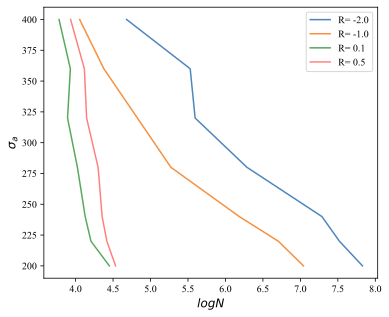

In [106]:
font1 = {'weight': 'bold',
         'size': 12}
fig,ax = plt.subplots(dpi=400,figsize=(6,5))
#color_list = [(23/255,23/255,23/255),"palegoldenrod",'palegreen',"paleturquoise"]
color_list = [(77/255,133/255,189/255),(247/255,144/255,61/255),(89/255,169/255,90/255),(254/255,129/255,125/255)]
i= 0
for R in list_R:
    plt.plot(df_plot[df_plot.R==R]["predict"],df_plot[df_plot.R==R]["S"]
             ,label="R= "+str(R),c=color_list[i],alpha=1)
    i=i+1
ax.set_xlabel("$logN$",font1)
ax.set_ylabel("$σ_a$",font1)
plt.legend()
plt.savefig(f'./R_DP.svg', format='svg')
plt.show()

#### UTS

In [96]:
list_UTS = sorted(list([500,600,700,800]))
print(list_UTS)

df_sencity = df_all[coulumns].groupby(["S-N_index","UTS","TYS","R","S","Fatigue Strength"],as_index=False).mean()
df1 = df_sencity[df_sencity["S-N_index"]==21][["S-N_index","TYS","R","S","Fatigue Strength"]]
df2 = pd.DataFrame({"UTS":list_UTS})
def product_df(df1,df2):
    df1["key"]=1
    df2["key"]=1
    df_merged = pd.merge(df1,df2,on='key')
    del df_merged["key"]
    return df_merged
df_merged = product_df(df1,df2)
df_merged.head()

[500, 600, 700, 800]


S-N_index  TYS    R      S  Fatigue Strength  UTS
0         21  531 -1.0  200.0        194.805503  500
1         21  531 -1.0  200.0        194.805503  600
2         21  531 -1.0  200.0        194.805503  700
3         21  531 -1.0  200.0        194.805503  800
4         21  531 -1.0  220.0        194.805503  500

In [97]:
virtual_data = feature_generation(df_merged)[features]
virtual_data["predict"] = model.predict(virtual_data.values)
virtual_data["UTS"] = df_merged["UTS"]
virtual_data["S"] = df_merged["S"]
virtual_data.head()

TYS  Fatigue Strength    Stussi      $∆σ^3$   $∆σ^2$  $σ_{min}^{0.1}$  \
0  531        194.805503  1.047971   8000000.0  40000.0         1.698646   
1  531        194.805503  1.335654   8000000.0  40000.0         1.698646   
2  531        194.805503  1.558797   8000000.0  40000.0         1.698646   
3  531        194.805503  1.741119   8000000.0  40000.0         1.698646   
4  531        194.805503  0.804921  10648000.0  48400.0         1.714914   

   $σ_{min}^{1.5}$  $σ_{min}^2$  $σ_{min}^{2.5}$  $σ_{max}^{1.5}$   predict  \
0      2828.427125      40000.0    565685.424949      2828.427125  6.640785   
1      2828.427125      40000.0    565685.424949      2828.427125  7.041921   
2      2828.427125      40000.0    565685.424949      2828.427125  7.309221   
3      2828.427125      40000.0    565685.424949      2828.427125  7.871067   
4      3263.127334      48400.0    717888.013551      3263.127334  6.442079   

   UTS      S  
0  500  200.0  
1  600  200.0  
2  700  200.0  
3  800  200.0  
4  500  220.0

In [98]:
df_plot = virtual_data.groupby(["S","UTS"],as_index=False).mean()
df_plot.head()

S  UTS  TYS  Fatigue Strength    Stussi      $∆σ^3$   $∆σ^2$  \
0  200.0  500  531        194.805503  1.047971   8000000.0  40000.0   
1  200.0  600  531        194.805503  1.335654   8000000.0  40000.0   
2  200.0  700  531        194.805503  1.558797   8000000.0  40000.0   
3  200.0  800  531        194.805503  1.741119   8000000.0  40000.0   
4  220.0  500  531        194.805503  0.804921  10648000.0  48400.0   

   $σ_{min}^{0.1}$  $σ_{min}^{1.5}$  $σ_{min}^2$  $σ_{min}^{2.5}$  \
0         1.698646      2828.427125      40000.0    565685.424949   
1         1.698646      2828.427125      40000.0    565685.424949   
2         1.698646      2828.427125      40000.0    565685.424949   
3         1.698646      2828.427125      40000.0    565685.424949   
4         1.714914      3263.127334      48400.0    717888.013551   

   $σ_{max}^{1.5}$   predict  
0      2828.427125  6.640785  
1      2828.427125  7.041921  
2      2828.427125  7.309221  
3      2828.427125  7.871067  
4      3263.127334  6.442079

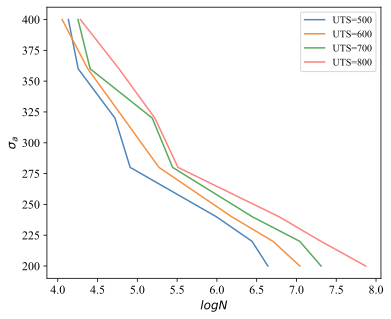

In [102]:
# plot
fig,ax = plt.subplots(dpi=400,figsize=(6,5))
color_list = [(77/255,133/255,189/255),(247/255,144/255,61/255),(89/255,169/255,90/255),(254/255,129/255,125/255)]
i= 0
for UTS in list_UTS:
    plt.plot(df_plot[df_plot.UTS==UTS]["predict"],df_plot[df_plot.UTS==UTS]["S"]
             ,label="UTS="+str(UTS),c=color_list[i])
    i=i+1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel("$logN$",font1)
ax.set_ylabel("$σ_a$",font1)
plt.legend()
plt.savefig(f'./UTS_DP.svg', format='svg')
plt.show()

# baseline model

In [73]:
baseline_features = ["UTS","TYS","R","$σ_{a}$","$Logσ_{a}$","$σ_{min}$","$σ_{max}$"]

['UTS', 'TYS', 'R', '$σ_{a}$', '$Logσ_{a}$', '$σ_{min}$', '$σ_{max}$']
MRE： 3.108961992846086
样本个数  257
均方根误差RMSE  0.599
均方差MSE  0.359
平均绝对误差MAE  0.446
R2： 0.742


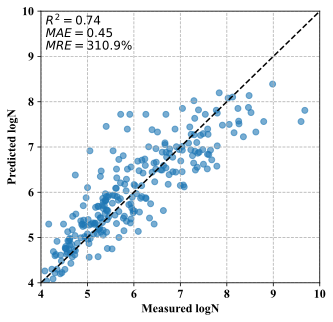

In [74]:
# setting
model_name = "baseline"
features = baseline_features

plt.rc('font',family='Times New Roman',size=12)
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
y_predict_list = []
y_true_list = []
index_list = []

x = df_curve[features].values
#x = df_curve[X_columns].values
print(features)
for train_index, test_index in logo.split(x, Y, groups_array):# 根据合金的名称将其分组
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = GradientBoostingRegressor(random_state=0)
    model.fit(X_train,Y_train)
    
    y_predict_list.extend(model.predict(X_test))
    y_true_list.extend(Y_test)
    index_list.extend(index[test_index])
# calculate mre
mre = mean_relative_error(np.power(10,y_true_list), np.power(10,y_predict_list))
print("MRE：",mre)

evalucation_matrix = evaluate_model_plot(y_true_list,y_predict_list,show=False)

# true
y_true = y_true_list
y_predict = y_predict_list
plt.figure(figsize=(5, 5), dpi=400)
plt.rcParams['font.sans-serif'] = ['Arial']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
plt.grid(linestyle="--")  # 设置背景网格线为虚线
ax = plt.gca()  # 获取坐标轴对象
plt.scatter(y_true, y_predict,alpha=0.6)
plt.plot([4, 10], [4, 10], color='black',linestyle="--")

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("Measured logN", fontsize=12, fontweight='bold')
plt.ylabel("Predicted logN", fontsize=12, fontweight='bold')
plt.xlim(4, 10)  # 设置x轴的范围
plt.ylim(4, 10)
plt.text(4.1,9.15,"$R^2={r2}$\n$MAE={MAE}$\n$MRE={MRE}\%$".format(r2=round(evalucation_matrix["R2"],2)
                                                                ,MAE=round(evalucation_matrix["MAE"],2)
                                                                ,MRE=round(mre*100,1)
                                                              ))
# 
plt.savefig(f'./sn_evaluation_{model_name}.svg', format='svg')
plt.show()

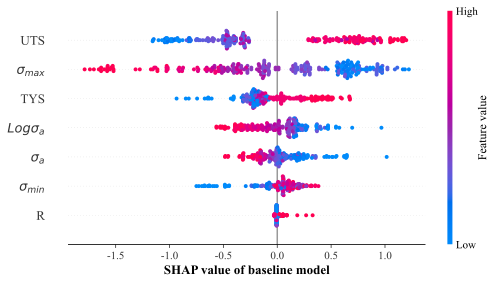

In [75]:
import shap
X = df_curve[features]
explainer = shap.TreeExplainer(model,feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X)
#
plt.figure(figsize=(5, 10),dpi=300)         
shap.summary_plot(shap_values, X,show=False)
plt.xlabel(f"SHAP value of {model_name} model" , fontweight='bold')

plt.savefig(f'./SN_shap_{model_name}.png')
plt.show()

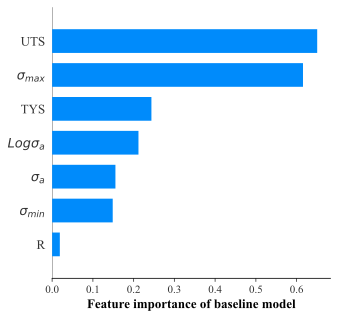

In [76]:
plt.figure(figsize=(5, 10),dpi=300)
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.xlabel(f"Feature importance of {model_name} model" , fontweight='bold')
plt.savefig(f'./SN_feature_importance_{model_name}.png')
plt.show()

# guessing model

In [35]:
guessing_features = ["UTS","TYS","R","$σ_{a}$","$Logσ_{a}$","$σ_{min}$","$σ_{max}$",'$σ_{a}^3$', '$σ_{a}^2$', '$σ_{a}^{0.5}$', '$σ_{a}^{0.1}$',
      '$σ_{m}$', '$σ_{min}^{0.1}$', '$σ_{min}^{0.5}$',
       '$σ_{min}^{1.5}$', '$σ_{min}^2$', '$σ_{min}^{2.5}$', '$σ_{min}^3$',
       '$σ_{max}^{0.1}$', '$σ_{max}^{0.5}$', '$σ_{max}^{1.5}$', '$σ_{max}^2$',
       '$σ_{max}^{2.5}$', '$σ_{max}^3$']

In [34]:
df_curve.columns

Index(['S-N_index', 'UTS', 'TYS', 'R', '$σ_{a}$', 'Fatigue Strength', 'LgN',
       '$Logσ_{a}$', 'Stussi', '$σ_{a}^3$', '$σ_{a}^2$', '$σ_{a}^{0.5}$',
       '$σ_{a}^{0.1}$', '$σ_{max}$', '$σ_{min}$', '$σ_{m}$', '$σ_{min}^{0.1}$',
       '$σ_{min}^{0.5}$', '$σ_{min}^{1.5}$', '$σ_{min}^2$', '$σ_{min}^{2.5}$',
       '$σ_{min}^3$', '$σ_{max}^{0.1}$', '$σ_{max}^{0.5}$', '$σ_{max}^{1.5}$',
       '$σ_{max}^2$', '$σ_{max}^{2.5}$', '$σ_{max}^3$'],
      dtype='object')

['UTS', 'TYS', 'R', '$σ_{a}$', '$Logσ_{a}$', '$σ_{min}$', '$σ_{max}$', '$σ_{a}^3$', '$σ_{a}^2$', '$σ_{a}^{0.5}$', '$σ_{a}^{0.1}$', '$σ_{m}$', '$σ_{min}^{0.1}$', '$σ_{min}^{0.5}$', '$σ_{min}^{1.5}$', '$σ_{min}^2$', '$σ_{min}^{2.5}$', '$σ_{min}^3$', '$σ_{max}^{0.1}$', '$σ_{max}^{0.5}$', '$σ_{max}^{1.5}$', '$σ_{max}^2$', '$σ_{max}^{2.5}$', '$σ_{max}^3$']
MRE： 2.188567535276678
样本个数  257
均方根误差RMSE  0.573
均方差MSE  0.329
平均绝对误差MAE  0.43
R2： 0.763


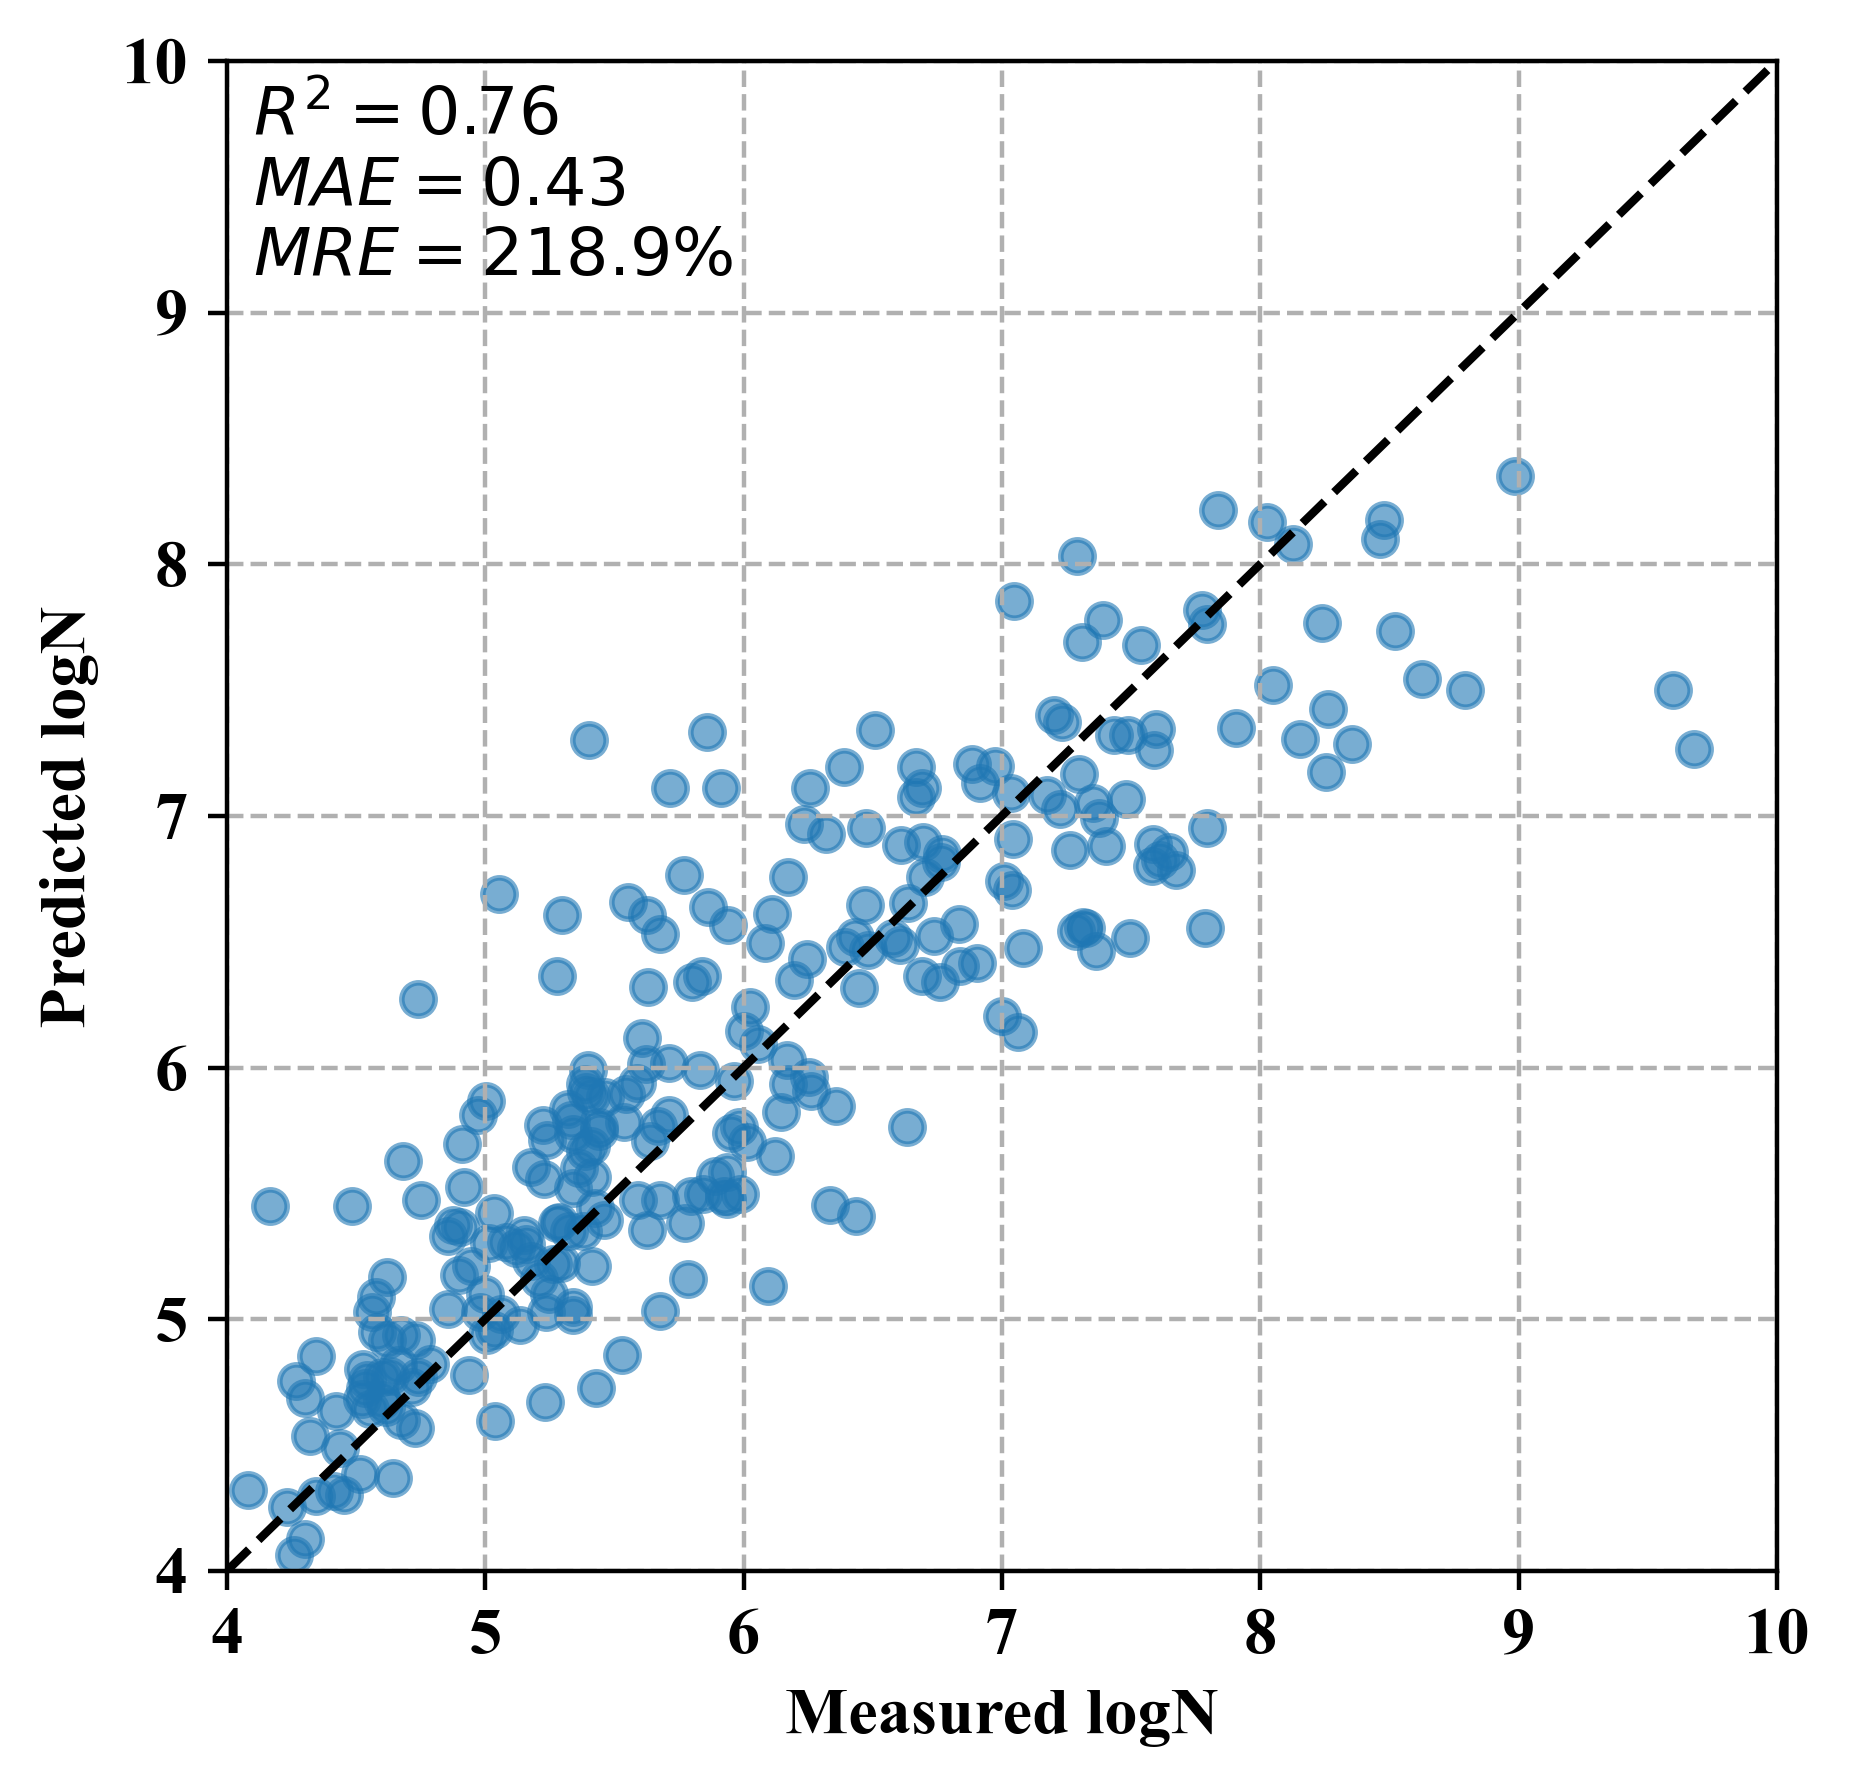

In [36]:
# setting
model_name = "guessing"
features = guessing_features

plt.rc('font',family='Times New Roman',size=12)
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
y_predict_list = []
y_true_list = []
index_list = []

x = df_curve[features].values
print(features)
for train_index, test_index in logo.split(x, Y, groups_array):# 根据合金的名称将其分组
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = GradientBoostingRegressor(random_state=0)
    model.fit(X_train,Y_train)
    
    y_predict_list.extend(model.predict(X_test))
    y_true_list.extend(Y_test)
    index_list.extend(index[test_index])
# calculate mre
mre = mean_relative_error(np.power(10,y_true_list), np.power(10,y_predict_list))
print("MRE：",mre)

evalucation_matrix = evaluate_model_plot(y_true_list,y_predict_list,show=False)

# true
y_true = y_true_list
y_predict = y_predict_list
plt.figure(figsize=(5, 5), dpi=400)
plt.rcParams['font.sans-serif'] = ['Arial']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
plt.grid(linestyle="--")  # 设置背景网格线为虚线
ax = plt.gca()  # 获取坐标轴对象
plt.scatter(y_true, y_predict,alpha=0.6)
plt.plot([4, 10], [4, 10], color='black',linestyle="--")

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("Measured logN", fontsize=12, fontweight='bold')
plt.ylabel("Predicted logN", fontsize=12, fontweight='bold')
plt.xlim(4, 10)  # 设置x轴的范围
plt.ylim(4, 10)
plt.text(4.1,9.15,"$R^2={r2}$\n$MAE={MAE}$\n$MRE={MRE}\%$".format(r2=round(evalucation_matrix["R2"],2)
                                                                ,MAE=round(evalucation_matrix["MAE"],2)
                                                                ,MRE=round(mre*100,1)
                                                              ))
# 
plt.savefig(f'./sn_evaluation_{model_name}.svg', format='svg')
plt.show()

# estimation model

In [37]:
estimation_features = ["UTS","TYS","R","$σ_{a}$","$Logσ_{a}$","$σ_{min}$","$σ_{max}$","Stussi"]

['UTS', 'TYS', 'R', '$σ_{a}$', '$Logσ_{a}$', '$σ_{min}$', '$σ_{max}$', 'Stussi']
MRE： 1.8703088337799127
样本个数  257
均方根误差RMSE  0.584
均方差MSE  0.341
平均绝对误差MAE  0.431
R2： 0.754


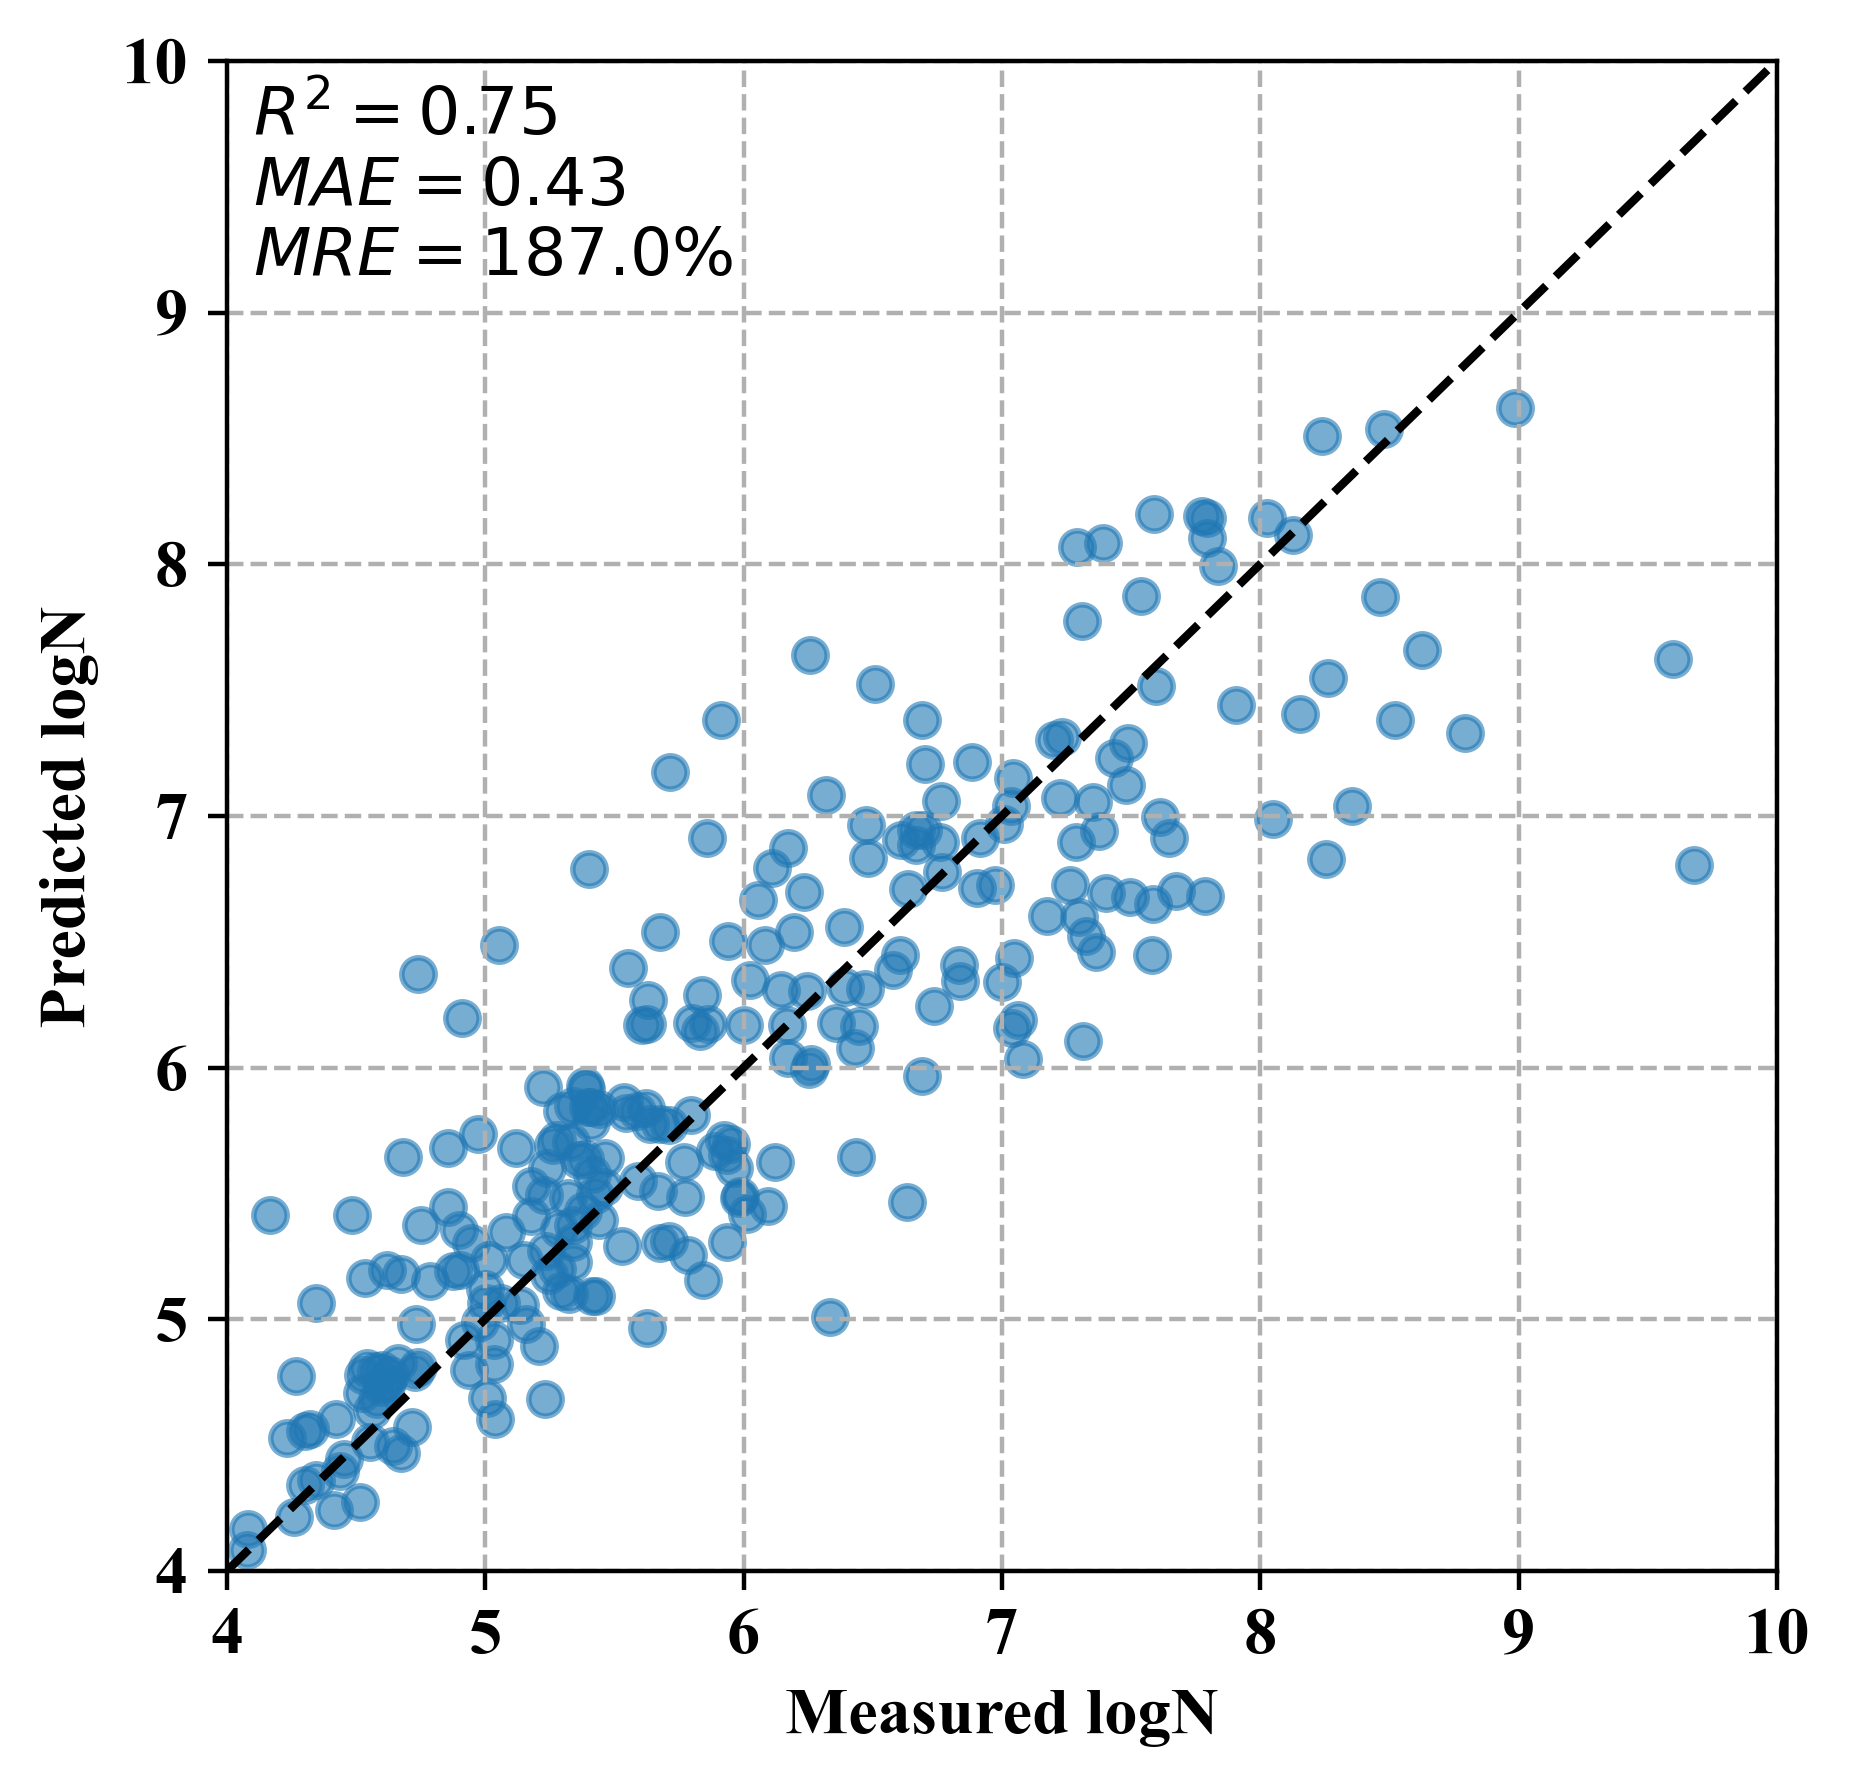

In [38]:
# setting
model_name = "estimation"
features = estimation_features

plt.rc('font',family='Times New Roman',size=12)
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
y_predict_list = []
y_true_list = []
index_list = []

x = df_curve[features].values
#x = df_curve[X_columns].values
print(features)
for train_index, test_index in logo.split(x, Y, groups_array):# 根据合金的名称将其分组
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = GradientBoostingRegressor(random_state=0)
    model.fit(X_train,Y_train)
    
    y_predict_list.extend(model.predict(X_test))
    y_true_list.extend(Y_test)
    index_list.extend(index[test_index])
# calculate mre
mre = mean_relative_error(np.power(10,y_true_list), np.power(10,y_predict_list))
print("MRE：",mre)

evalucation_matrix = evaluate_model_plot(y_true_list,y_predict_list,show=False)

# true
y_true = y_true_list
y_predict = y_predict_list
plt.figure(figsize=(5, 5), dpi=400)
plt.rcParams['font.sans-serif'] = ['Arial']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
plt.grid(linestyle="--")  # 设置背景网格线为虚线
ax = plt.gca()  # 获取坐标轴对象
plt.scatter(y_true, y_predict,alpha=0.6)
plt.plot([4, 10], [4, 10], color='black',linestyle="--")

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("Measured logN", fontsize=12, fontweight='bold')
plt.ylabel("Predicted logN", fontsize=12, fontweight='bold')
plt.xlim(4, 10)  # 设置x轴的范围
plt.ylim(4, 10)
plt.text(4.1,9.15,"$R^2={r2}$\n$MAE={MAE}$\n$MRE={MRE}\%$".format(r2=round(evalucation_matrix["R2"],2)
                                                                ,MAE=round(evalucation_matrix["MAE"],2)
                                                                ,MRE=round(mre*100,1)
                                                              ))
# 
plt.savefig(f'./sn_evaluation_{model_name}.svg', format='svg')
plt.show()

# Figures

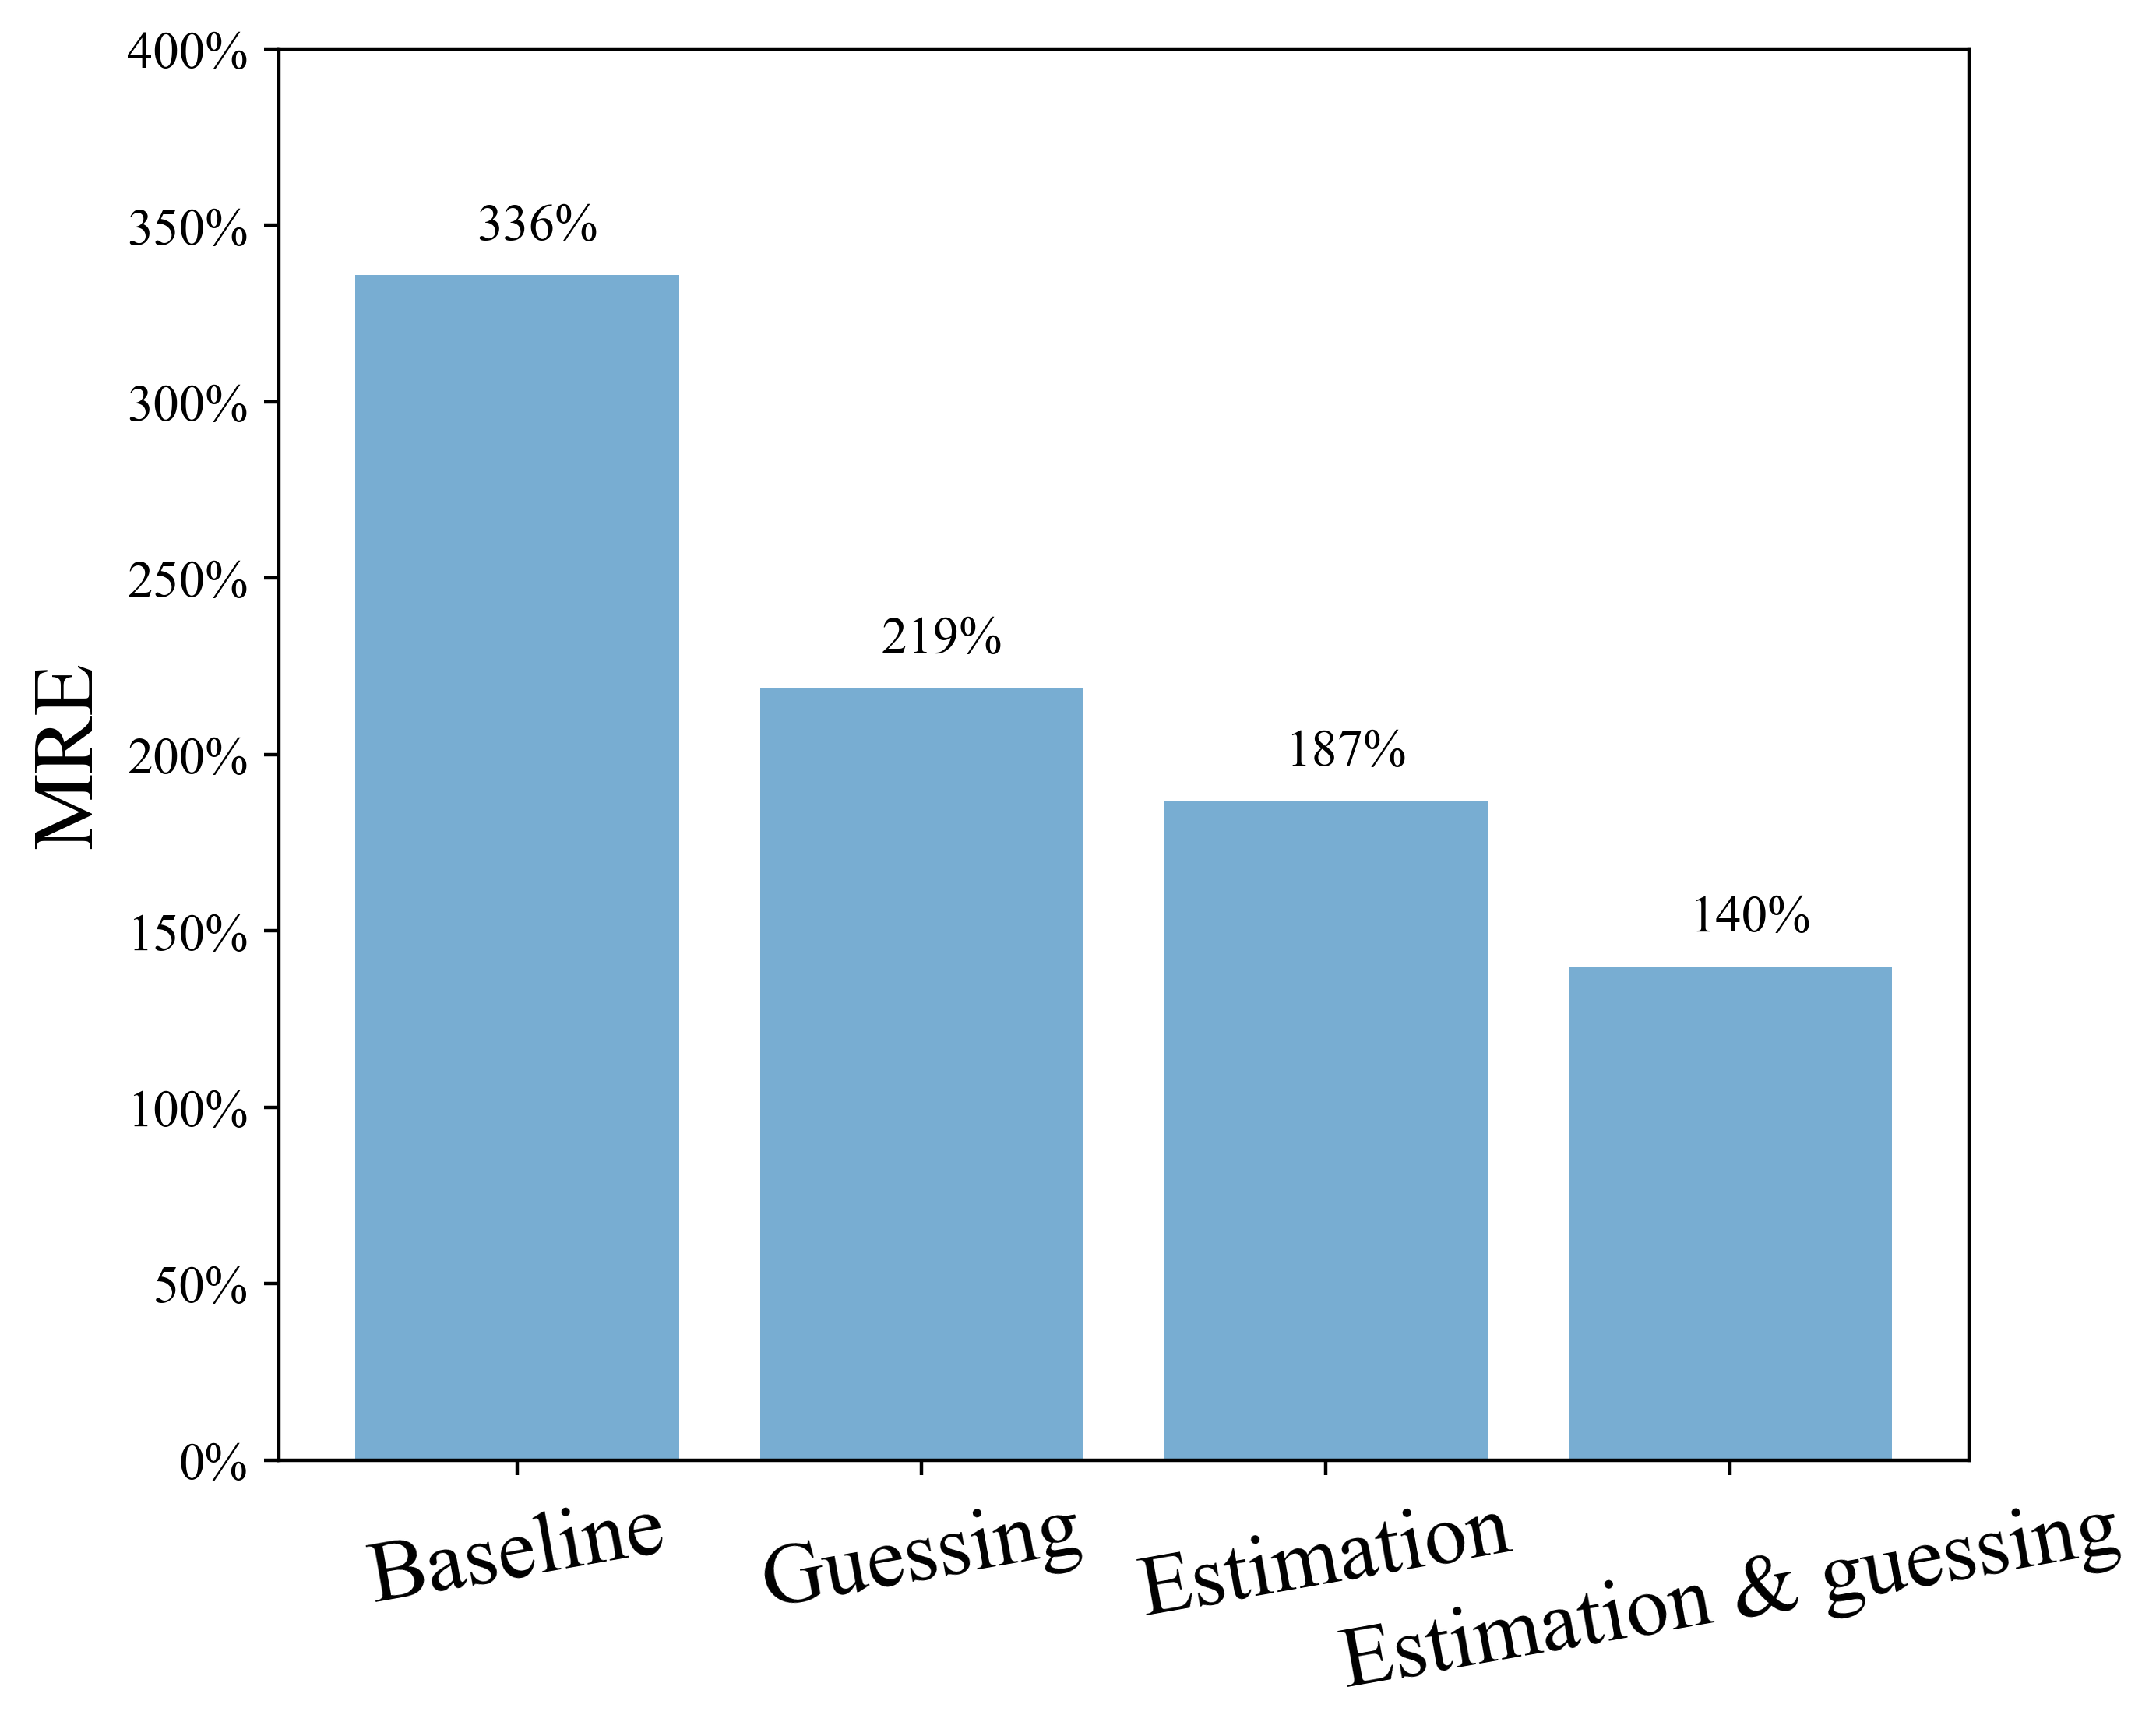

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
x = np.array(["Baseline", "Guessing", "Estimation", "Estimation & guessing"])
y = np.array([3.36, 2.19, 1.87, 1.40])

plt.figure(figsize=(7, 6),dpi=400)
ax = plt.gca()
plt.bar(x, y,alpha=0.6)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=12)
plt.ylim(0, 4)
plt.ylabel("MRE",fontsize=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

for tick in ax.get_xticklabels():
    tick.set_rotation(10)
plt.text(-0.1,3.46,"336%",fontsize=12)
plt.text(0.9,2.29,"219%",fontsize=12)
plt.text(1.9,1.97,"187%",fontsize=12)
plt.text(2.9,1.5,"140%",fontsize=12)
plt.savefig('./metric_bar.svg', format='svg')  # nkscape
plt.show()